<a href="https://colab.research.google.com/github/Hillary30/Music-Genre-Classification/blob/main/COSC_4368_Audio_Classification_Project4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade kaggle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import TensorDataset
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader
import os

from IPython.display import Audio
from tqdm import tqdm

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hillarynguyen","key":"fd608c59454f3b92bf901e7339cae9a1"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.21G/1.21G [00:13<00:00, 77.9MB/s]
100% 1.21G/1.21G [00:13<00:00, 98.9MB/s]


In [ ]:
! unzip gtzan-dataset-music-genre-classification

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [ ]:
df = pd.read_csv('./Data/features_3_sec.csv')
#df = pd.read_csv('./Data/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
df['label'].value_counts()

blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: label, dtype: int64

In [ ]:
label = list(df['label'].unique())
df['label'] = df['label'].apply(lambda x: label.index(x))
df['label'].value_counts()

0    1000
5    1000
6    1000
7    1000
8    1000
3     999
1     998
4     998
9     998
2     997
Name: label, dtype: int64

In [ ]:
model1 = nn.Sequential(
    nn.BatchNorm1d(57),
    nn.Linear(57, 100),
    nn.Dropout(0.4),
    nn.ReLU(),
    nn.Linear(100, 10),
)

model2 = nn.Sequential(
    nn.BatchNorm1d(57),
    nn.Linear(57, 512),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.4),

    nn.Linear(256, 128),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.3),

    nn.Linear(128, 64),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.2),

    nn.Linear(64, 10),
)

In [ ]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Final Test Accuracy', 'Sample Number'])
all_iterations_df = pd.DataFrame(columns=['Model', 'Test Accuracy', 'Sample Number'])

num_epochs = 150
#num_epochs = 250

for sample_index in range(5): #5 different samples for 3 models in 150 epochs
  train_data, test_data = train_test_split(df, train_size = 0.8, random_state = 1)
  scaler = StandardScaler()
  scaled_train_features = scaler.fit_transform(train_data.drop(['filename', 'length', 'label'], axis=1))
  scaled_test_features = scaler.transform(test_data.drop(['filename', 'length', 'label'], axis=1))
  # Create PyTorch datasets and data loaders
  train_labels = torch.tensor(train_data['label'].values, dtype=int)
  test_labels = torch.tensor(test_data['label'].values, dtype=int)
  train_dataset = TensorDataset(torch.tensor(scaled_train_features, dtype=torch.float32), train_labels)
  test_dataset = TensorDataset(torch.tensor(scaled_test_features, dtype=torch.float32), test_labels)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

  model3 = nn.Sequential( #dependent on scaled_train_features
    nn.BatchNorm1d(scaled_train_features.shape[1]),
    nn.Linear(scaled_train_features.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(64, 10),
  )

  model_list = [model1, model2, model3]
  #model_list = [model2, model3]


  for index, model in enumerate(model_list):
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Testing phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        print(f'Epoch: {epoch+1} / {num_epochs}, Train loss: {avg_train_loss:.4f}, Test accuracy: {test_accuracy:.4f}, Model {index+1}, Sample Number: {sample_index}')
        all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
        #all_iterations_df = all_iterations_df.append({'Model': f'Model {index+2}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
        if epoch+1 == 150:
            results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
        #if epoch+1 == 250:
        #    results_df = results_df.append({'Model': f'Model {index+2}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)



100%|██████████| 250/250 [00:00<00:00, 441.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.7708, Test accuracy: 0.5440, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 399.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.3504, Test accuracy: 0.6271, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 455.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.2184, Test accuracy: 0.6632, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 430.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.1276, Test accuracy: 0.6862, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 425.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 1.0657, Test accuracy: 0.7112, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 436.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 1.0213, Test accuracy: 0.7177, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 445.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 1.0035, Test accuracy: 0.7202, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 422.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.9663, Test accuracy: 0.7337, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 255.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.9492, Test accuracy: 0.7402, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 282.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.9175, Test accuracy: 0.7462, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 296.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.9118, Test accuracy: 0.7508, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 296.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.8924, Test accuracy: 0.7523, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 318.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.8698, Test accuracy: 0.7568, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 406.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.8544, Test accuracy: 0.7643, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 435.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.8568, Test accuracy: 0.7693, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 448.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.8496, Test accuracy: 0.7718, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 452.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.8467, Test accuracy: 0.7648, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 460.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.8178, Test accuracy: 0.7678, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 457.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.8247, Test accuracy: 0.7783, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 428.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.8049, Test accuracy: 0.7768, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 433.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.7936, Test accuracy: 0.7828, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 429.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.8011, Test accuracy: 0.7863, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 427.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.7945, Test accuracy: 0.7888, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 432.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.7864, Test accuracy: 0.7853, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 422.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.7716, Test accuracy: 0.7898, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 408.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.7539, Test accuracy: 0.7923, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 339.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.7594, Test accuracy: 0.7943, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 258.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.7550, Test accuracy: 0.7918, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 276.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.7653, Test accuracy: 0.7973, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 274.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.7525, Test accuracy: 0.7938, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 285.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.7384, Test accuracy: 0.8038, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 415.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.7423, Test accuracy: 0.8073, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 417.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.7341, Test accuracy: 0.8058, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 440.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.7236, Test accuracy: 0.8058, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 455.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.7170, Test accuracy: 0.8053, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 432.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.7235, Test accuracy: 0.8073, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 392.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.7162, Test accuracy: 0.8138, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 440.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.7038, Test accuracy: 0.8113, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 446.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.7026, Test accuracy: 0.8078, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 407.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.6997, Test accuracy: 0.8123, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 462.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.6947, Test accuracy: 0.8193, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 440.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.6865, Test accuracy: 0.8153, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 418.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.6903, Test accuracy: 0.8188, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 399.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.6793, Test accuracy: 0.8143, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 404.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.6724, Test accuracy: 0.8143, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 316.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.6937, Test accuracy: 0.8168, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 294.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.6712, Test accuracy: 0.8208, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 182.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.6779, Test accuracy: 0.8208, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 266.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.6734, Test accuracy: 0.8243, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 400.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.6623, Test accuracy: 0.8308, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 418.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.6767, Test accuracy: 0.8288, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 418.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.6534, Test accuracy: 0.8293, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 400.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.6488, Test accuracy: 0.8298, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 446.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.6705, Test accuracy: 0.8288, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 437.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.6543, Test accuracy: 0.8343, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 412.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.6517, Test accuracy: 0.8398, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 418.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.6493, Test accuracy: 0.8288, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 420.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.6522, Test accuracy: 0.8383, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 422.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.6384, Test accuracy: 0.8363, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 448.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.6176, Test accuracy: 0.8368, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 433.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.6402, Test accuracy: 0.8388, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 405.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.6489, Test accuracy: 0.8383, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 390.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.6227, Test accuracy: 0.8428, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 291.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.6402, Test accuracy: 0.8403, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 307.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.6360, Test accuracy: 0.8428, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 279.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.6431, Test accuracy: 0.8413, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 307.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.6289, Test accuracy: 0.8338, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 314.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.6325, Test accuracy: 0.8433, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 438.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.6300, Test accuracy: 0.8468, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 421.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.6198, Test accuracy: 0.8468, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 430.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.6349, Test accuracy: 0.8458, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 435.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.6076, Test accuracy: 0.8483, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 440.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.6121, Test accuracy: 0.8468, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 443.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.6101, Test accuracy: 0.8504, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 450.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.6197, Test accuracy: 0.8463, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 440.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.6259, Test accuracy: 0.8473, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 452.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.6052, Test accuracy: 0.8483, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 422.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.6034, Test accuracy: 0.8539, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 430.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.6146, Test accuracy: 0.8529, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 409.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.6104, Test accuracy: 0.8478, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 432.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.6079, Test accuracy: 0.8519, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 426.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.6028, Test accuracy: 0.8463, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 265.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.6091, Test accuracy: 0.8509, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 271.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.5912, Test accuracy: 0.8529, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 286.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.5976, Test accuracy: 0.8614, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 261.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.5914, Test accuracy: 0.8574, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 360.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.5980, Test accuracy: 0.8584, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 421.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.5948, Test accuracy: 0.8544, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 416.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.5940, Test accuracy: 0.8539, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 430.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.5852, Test accuracy: 0.8579, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 414.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.5988, Test accuracy: 0.8529, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 437.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.5892, Test accuracy: 0.8569, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 421.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.5901, Test accuracy: 0.8564, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 412.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.5875, Test accuracy: 0.8529, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 436.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.5821, Test accuracy: 0.8584, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 456.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.6003, Test accuracy: 0.8579, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 404.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.5683, Test accuracy: 0.8589, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 433.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.5920, Test accuracy: 0.8599, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 403.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.5859, Test accuracy: 0.8644, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 395.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.5808, Test accuracy: 0.8634, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 314.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.5816, Test accuracy: 0.8669, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 310.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.5695, Test accuracy: 0.8599, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 318.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.5839, Test accuracy: 0.8584, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 289.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.5857, Test accuracy: 0.8634, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 300.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.5824, Test accuracy: 0.8629, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 320.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.5895, Test accuracy: 0.8634, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 407.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.5703, Test accuracy: 0.8674, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 421.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.5771, Test accuracy: 0.8669, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 399.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.5736, Test accuracy: 0.8609, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 435.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.5650, Test accuracy: 0.8699, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 428.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.5818, Test accuracy: 0.8594, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 442.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.5717, Test accuracy: 0.8634, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 437.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.5693, Test accuracy: 0.8704, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 421.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.5563, Test accuracy: 0.8664, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 423.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.5548, Test accuracy: 0.8649, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 443.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.5651, Test accuracy: 0.8659, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 390.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.5543, Test accuracy: 0.8579, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 419.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.5769, Test accuracy: 0.8659, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 445.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.5721, Test accuracy: 0.8669, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 331.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.5816, Test accuracy: 0.8654, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 269.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.5593, Test accuracy: 0.8649, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 261.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.5499, Test accuracy: 0.8624, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 285.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.5659, Test accuracy: 0.8679, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 278.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.5651, Test accuracy: 0.8674, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 438.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.5699, Test accuracy: 0.8749, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 409.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.5525, Test accuracy: 0.8764, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 439.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.5551, Test accuracy: 0.8694, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 454.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.5403, Test accuracy: 0.8669, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 432.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.5557, Test accuracy: 0.8654, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 403.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.5541, Test accuracy: 0.8724, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 243.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.5605, Test accuracy: 0.8699, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 285.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.5485, Test accuracy: 0.8684, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 436.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.5569, Test accuracy: 0.8749, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 424.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.5585, Test accuracy: 0.8739, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 411.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.5616, Test accuracy: 0.8684, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 405.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.5594, Test accuracy: 0.8729, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 316.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.5486, Test accuracy: 0.8709, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 294.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.5492, Test accuracy: 0.8699, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 286.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.5564, Test accuracy: 0.8784, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 303.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.5360, Test accuracy: 0.8729, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 317.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.5491, Test accuracy: 0.8724, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 358.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.5475, Test accuracy: 0.8724, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 418.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.5483, Test accuracy: 0.8674, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 443.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.5516, Test accuracy: 0.8759, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 392.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.5434, Test accuracy: 0.8699, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 413.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.5576, Test accuracy: 0.8704, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 423.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.5239, Test accuracy: 0.8694, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 436.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.5494, Test accuracy: 0.8739, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 424.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.5409, Test accuracy: 0.8734, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 425.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.5397, Test accuracy: 0.8694, Model 1, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 165.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.6853, Test accuracy: 0.6111, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.2457, Test accuracy: 0.6992, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 84.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.0938, Test accuracy: 0.7262, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 109.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.0354, Test accuracy: 0.7492, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 155.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.9889, Test accuracy: 0.7518, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 155.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.9199, Test accuracy: 0.7623, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.9030, Test accuracy: 0.7803, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 143.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.8645, Test accuracy: 0.7863, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 132.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.8256, Test accuracy: 0.7933, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 109.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.8095, Test accuracy: 0.8013, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 104.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.7910, Test accuracy: 0.8148, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 138.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.7500, Test accuracy: 0.8113, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.7392, Test accuracy: 0.8258, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.7310, Test accuracy: 0.8203, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.7103, Test accuracy: 0.8323, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.6889, Test accuracy: 0.8343, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.6841, Test accuracy: 0.8353, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 102.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.6655, Test accuracy: 0.8413, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.6411, Test accuracy: 0.8524, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.6260, Test accuracy: 0.8549, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.6159, Test accuracy: 0.8574, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.6106, Test accuracy: 0.8574, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.6044, Test accuracy: 0.8664, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 124.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5796, Test accuracy: 0.8714, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5733, Test accuracy: 0.8629, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 126.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5660, Test accuracy: 0.8714, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5533, Test accuracy: 0.8709, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 151.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5731, Test accuracy: 0.8709, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 144.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5577, Test accuracy: 0.8829, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5342, Test accuracy: 0.8774, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 118.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5326, Test accuracy: 0.8844, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.5295, Test accuracy: 0.8894, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 119.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.5115, Test accuracy: 0.8849, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.5147, Test accuracy: 0.8899, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 136.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.5049, Test accuracy: 0.8889, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.5070, Test accuracy: 0.8954, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4864, Test accuracy: 0.8944, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 116.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4797, Test accuracy: 0.9039, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 103.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4794, Test accuracy: 0.9004, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 125.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4797, Test accuracy: 0.9014, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4618, Test accuracy: 0.8959, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4704, Test accuracy: 0.9049, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4568, Test accuracy: 0.8984, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4586, Test accuracy: 0.8974, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 117.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4676, Test accuracy: 0.9084, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 104.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4617, Test accuracy: 0.8979, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 114.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4475, Test accuracy: 0.9094, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4502, Test accuracy: 0.8999, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.4440, Test accuracy: 0.9089, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.4332, Test accuracy: 0.9074, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 138.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.4266, Test accuracy: 0.9059, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 123.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.4268, Test accuracy: 0.9124, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 108.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.4276, Test accuracy: 0.9154, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 118.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.4180, Test accuracy: 0.9064, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 147.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.4199, Test accuracy: 0.9104, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.4244, Test accuracy: 0.9214, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.4055, Test accuracy: 0.9134, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 143.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.4098, Test accuracy: 0.9149, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 130.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.4065, Test accuracy: 0.9169, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 102.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.4032, Test accuracy: 0.9134, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 115.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.3964, Test accuracy: 0.9184, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.4052, Test accuracy: 0.9209, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 132.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.3794, Test accuracy: 0.9149, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.4121, Test accuracy: 0.9204, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.3993, Test accuracy: 0.9209, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.3823, Test accuracy: 0.9249, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.3729, Test accuracy: 0.9174, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 113.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.3917, Test accuracy: 0.9199, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 147.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.3753, Test accuracy: 0.9269, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 155.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.3772, Test accuracy: 0.9229, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 157.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.3719, Test accuracy: 0.9289, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.3768, Test accuracy: 0.9229, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.3788, Test accuracy: 0.9279, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.3605, Test accuracy: 0.9279, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 100.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.3590, Test accuracy: 0.9304, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.3742, Test accuracy: 0.9239, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 153.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.3460, Test accuracy: 0.9299, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 151.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.3489, Test accuracy: 0.9254, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.3601, Test accuracy: 0.9254, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 150.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.3735, Test accuracy: 0.9254, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 116.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.3582, Test accuracy: 0.9269, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 103.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.3616, Test accuracy: 0.9299, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.3861, Test accuracy: 0.9234, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 155.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.3501, Test accuracy: 0.9304, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 151.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.3608, Test accuracy: 0.9239, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.3492, Test accuracy: 0.9304, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.3462, Test accuracy: 0.9269, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 125.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.3553, Test accuracy: 0.9379, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.3498, Test accuracy: 0.9329, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 117.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.3450, Test accuracy: 0.9299, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.3554, Test accuracy: 0.9324, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.3425, Test accuracy: 0.9314, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.3329, Test accuracy: 0.9294, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.3498, Test accuracy: 0.9359, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.3320, Test accuracy: 0.9289, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 101.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.3348, Test accuracy: 0.9319, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 112.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.3315, Test accuracy: 0.9329, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 156.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.3311, Test accuracy: 0.9364, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 157.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.3459, Test accuracy: 0.9364, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 156.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.3193, Test accuracy: 0.9429, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.3461, Test accuracy: 0.9264, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.3361, Test accuracy: 0.9419, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 116.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.3329, Test accuracy: 0.9274, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.3140, Test accuracy: 0.9374, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 129.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.3372, Test accuracy: 0.9319, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 156.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.3045, Test accuracy: 0.9249, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.3350, Test accuracy: 0.9344, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 156.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.3146, Test accuracy: 0.9354, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.3304, Test accuracy: 0.9409, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 127.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.3267, Test accuracy: 0.9314, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 109.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.3359, Test accuracy: 0.9349, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 120.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.3086, Test accuracy: 0.9359, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 159.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.3110, Test accuracy: 0.9324, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.3230, Test accuracy: 0.9339, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.3262, Test accuracy: 0.9409, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.3173, Test accuracy: 0.9339, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 135.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.3101, Test accuracy: 0.9374, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 90.01it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2967, Test accuracy: 0.9364, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 114.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.3146, Test accuracy: 0.9379, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.3035, Test accuracy: 0.9344, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.3110, Test accuracy: 0.9354, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 144.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2947, Test accuracy: 0.9359, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.3069, Test accuracy: 0.9379, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 153.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.3093, Test accuracy: 0.9334, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2877, Test accuracy: 0.9399, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 109.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2953, Test accuracy: 0.9379, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 150.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.3143, Test accuracy: 0.9399, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 151.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.3056, Test accuracy: 0.9399, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.3088, Test accuracy: 0.9364, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 150.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.3032, Test accuracy: 0.9394, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 150.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.3006, Test accuracy: 0.9389, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 119.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.3054, Test accuracy: 0.9404, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 112.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2936, Test accuracy: 0.9354, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 126.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.3008, Test accuracy: 0.9399, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 158.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2919, Test accuracy: 0.9434, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 155.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.3016, Test accuracy: 0.9349, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.3000, Test accuracy: 0.9369, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2986, Test accuracy: 0.9379, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 151.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2898, Test accuracy: 0.9399, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 105.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2849, Test accuracy: 0.9384, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 113.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2934, Test accuracy: 0.9349, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2885, Test accuracy: 0.9399, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2933, Test accuracy: 0.9379, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2887, Test accuracy: 0.9439, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2841, Test accuracy: 0.9429, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2917, Test accuracy: 0.9394, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 113.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2866, Test accuracy: 0.9429, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 102.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2964, Test accuracy: 0.9369, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 131.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2830, Test accuracy: 0.9474, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 150.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2740, Test accuracy: 0.9419, Model 2, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.7267, Test accuracy: 0.5771, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.2901, Test accuracy: 0.6852, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.1517, Test accuracy: 0.7082, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 130.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.0517, Test accuracy: 0.7217, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 103.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.9904, Test accuracy: 0.7392, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 126.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.9411, Test accuracy: 0.7568, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.9186, Test accuracy: 0.7633, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 155.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.8617, Test accuracy: 0.7763, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 153.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.8471, Test accuracy: 0.7938, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.8169, Test accuracy: 0.8073, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.7902, Test accuracy: 0.8043, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 105.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.7585, Test accuracy: 0.8198, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.7284, Test accuracy: 0.8233, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.7153, Test accuracy: 0.8293, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.7287, Test accuracy: 0.8333, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.6988, Test accuracy: 0.8408, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.6731, Test accuracy: 0.8423, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.6643, Test accuracy: 0.8438, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.6331, Test accuracy: 0.8559, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.6071, Test accuracy: 0.8614, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.6086, Test accuracy: 0.8674, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.6057, Test accuracy: 0.8579, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.5835, Test accuracy: 0.8664, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5866, Test accuracy: 0.8764, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5601, Test accuracy: 0.8759, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 115.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5620, Test accuracy: 0.8829, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 108.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5469, Test accuracy: 0.8819, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 128.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5333, Test accuracy: 0.8814, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5320, Test accuracy: 0.8819, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 152.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5223, Test accuracy: 0.8849, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 147.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5221, Test accuracy: 0.8819, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 144.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.4989, Test accuracy: 0.8904, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 139.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.5051, Test accuracy: 0.9009, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 111.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4762, Test accuracy: 0.8974, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4978, Test accuracy: 0.8884, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4714, Test accuracy: 0.9029, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 147.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4659, Test accuracy: 0.8974, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4526, Test accuracy: 0.9024, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4539, Test accuracy: 0.9044, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 143.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4603, Test accuracy: 0.9019, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 107.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4324, Test accuracy: 0.9079, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 113.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4359, Test accuracy: 0.9109, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4129, Test accuracy: 0.9064, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4073, Test accuracy: 0.9164, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 153.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4069, Test accuracy: 0.9084, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 135.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4164, Test accuracy: 0.9104, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4087, Test accuracy: 0.9134, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 116.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.3956, Test accuracy: 0.9139, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 110.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.3946, Test accuracy: 0.9164, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 125.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.3868, Test accuracy: 0.9129, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 154.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.3839, Test accuracy: 0.9204, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.3722, Test accuracy: 0.9224, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 144.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.3819, Test accuracy: 0.9139, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 143.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.3822, Test accuracy: 0.9199, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.3811, Test accuracy: 0.9199, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 100.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.3642, Test accuracy: 0.9114, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 119.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.3568, Test accuracy: 0.9214, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.3728, Test accuracy: 0.9279, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 143.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.3458, Test accuracy: 0.9324, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.3527, Test accuracy: 0.9259, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.3448, Test accuracy: 0.9244, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 119.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.3521, Test accuracy: 0.9199, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.3458, Test accuracy: 0.9304, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 117.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.3321, Test accuracy: 0.9274, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.3362, Test accuracy: 0.9289, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 146.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.3287, Test accuracy: 0.9299, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 148.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.3265, Test accuracy: 0.9269, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 142.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.3177, Test accuracy: 0.9219, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 145.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.3341, Test accuracy: 0.9289, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 109.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.3150, Test accuracy: 0.9279, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.3172, Test accuracy: 0.9279, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 151.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.3086, Test accuracy: 0.9314, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 158.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.3130, Test accuracy: 0.9294, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.3211, Test accuracy: 0.9324, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 147.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.2896, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.3060, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 110.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.3050, Test accuracy: 0.9364, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 105.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.2863, Test accuracy: 0.9339, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 139.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.3060, Test accuracy: 0.9374, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 144.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.2994, Test accuracy: 0.9354, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.2865, Test accuracy: 0.9294, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 118.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.3029, Test accuracy: 0.9369, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 129.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.2798, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 101.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2924, Test accuracy: 0.9394, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2958, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 149.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.3131, Test accuracy: 0.9364, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 114.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2792, Test accuracy: 0.9364, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 131.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2759, Test accuracy: 0.9339, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 131.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2774, Test accuracy: 0.9284, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 135.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2713, Test accuracy: 0.9324, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 105.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2802, Test accuracy: 0.9319, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 105.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2673, Test accuracy: 0.9349, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 129.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2863, Test accuracy: 0.9384, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 132.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2840, Test accuracy: 0.9314, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 139.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2705, Test accuracy: 0.9334, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 134.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2804, Test accuracy: 0.9359, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 111.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2731, Test accuracy: 0.9384, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 101.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2772, Test accuracy: 0.9404, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 122.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2636, Test accuracy: 0.9449, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 138.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2507, Test accuracy: 0.9404, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2614, Test accuracy: 0.9424, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 141.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2649, Test accuracy: 0.9389, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 136.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2606, Test accuracy: 0.9389, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 117.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2584, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 102.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2531, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 116.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2733, Test accuracy: 0.9424, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 134.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2463, Test accuracy: 0.9374, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 128.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2645, Test accuracy: 0.9399, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2647, Test accuracy: 0.9354, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 128.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2600, Test accuracy: 0.9364, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 100.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2549, Test accuracy: 0.9394, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 98.06it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2477, Test accuracy: 0.9414, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 138.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2370, Test accuracy: 0.9409, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2639, Test accuracy: 0.9359, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 136.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2499, Test accuracy: 0.9454, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2304, Test accuracy: 0.9364, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 130.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2487, Test accuracy: 0.9394, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 101.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2408, Test accuracy: 0.9404, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 101.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2441, Test accuracy: 0.9419, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2493, Test accuracy: 0.9409, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 138.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2255, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2569, Test accuracy: 0.9389, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 135.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2489, Test accuracy: 0.9364, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 128.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2293, Test accuracy: 0.9434, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 101.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2372, Test accuracy: 0.9414, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 110.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2405, Test accuracy: 0.9389, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2514, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 136.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.2322, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 136.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2353, Test accuracy: 0.9414, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 143.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2461, Test accuracy: 0.9449, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 123.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.2293, Test accuracy: 0.9419, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 100.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2345, Test accuracy: 0.9384, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 108.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2525, Test accuracy: 0.9374, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 132.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2315, Test accuracy: 0.9394, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2352, Test accuracy: 0.9439, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 134.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2211, Test accuracy: 0.9409, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2285, Test accuracy: 0.9379, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 111.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2340, Test accuracy: 0.9414, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 106.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2261, Test accuracy: 0.9429, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 113.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2218, Test accuracy: 0.9419, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 137.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2330, Test accuracy: 0.9454, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 133.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2207, Test accuracy: 0.9434, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 135.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2259, Test accuracy: 0.9434, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 140.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2267, Test accuracy: 0.9429, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 111.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2120, Test accuracy: 0.9434, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 98.76it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2204, Test accuracy: 0.9399, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:02<00:00, 116.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2131, Test accuracy: 0.9434, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 131.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2197, Test accuracy: 0.9329, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 132.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2338, Test accuracy: 0.9399, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:01<00:00, 135.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2193, Test accuracy: 0.9424, Model 3, Sample Number: 0


100%|██████████| 250/250 [00:00<00:00, 381.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.5444, Test accuracy: 0.8749, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 415.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.5290, Test accuracy: 0.8664, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 364.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.5339, Test accuracy: 0.8729, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 262.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.5498, Test accuracy: 0.8774, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 287.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.5539, Test accuracy: 0.8709, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 268.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.5422, Test accuracy: 0.8719, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 256.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.5421, Test accuracy: 0.8779, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 250.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.5449, Test accuracy: 0.8764, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 380.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.5465, Test accuracy: 0.8684, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 371.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.5458, Test accuracy: 0.8729, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 381.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.5342, Test accuracy: 0.8704, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 403.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.5487, Test accuracy: 0.8774, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 403.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.5319, Test accuracy: 0.8824, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 383.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.5399, Test accuracy: 0.8744, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 427.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.5309, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 393.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.5400, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 396.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.5430, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 407.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.5327, Test accuracy: 0.8774, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 402.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.5266, Test accuracy: 0.8754, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 373.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.5427, Test accuracy: 0.8734, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 339.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.5387, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 279.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.5312, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 257.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.5460, Test accuracy: 0.8674, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 259.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5349, Test accuracy: 0.8724, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 256.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5366, Test accuracy: 0.8759, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 262.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5322, Test accuracy: 0.8774, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 366.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5252, Test accuracy: 0.8804, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 377.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5316, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 399.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5428, Test accuracy: 0.8744, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 393.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5377, Test accuracy: 0.8704, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 348.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5348, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 370.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.5198, Test accuracy: 0.8729, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 370.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.5380, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 366.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.5252, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 376.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.5284, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 380.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.5254, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 380.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.5303, Test accuracy: 0.8759, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 395.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.5081, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 291.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.5343, Test accuracy: 0.8744, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 287.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.5309, Test accuracy: 0.8754, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 257.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.5125, Test accuracy: 0.8729, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 261.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.5285, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 259.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.5193, Test accuracy: 0.8759, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 320.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.5284, Test accuracy: 0.8749, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 379.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.5296, Test accuracy: 0.8754, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 348.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.5128, Test accuracy: 0.8774, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 370.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.5356, Test accuracy: 0.8804, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 380.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.5060, Test accuracy: 0.8764, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 400.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.5214, Test accuracy: 0.8739, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 371.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.5184, Test accuracy: 0.8754, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 393.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.5300, Test accuracy: 0.8734, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 406.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.5212, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 382.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.5089, Test accuracy: 0.8769, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 372.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.5240, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 395.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.5256, Test accuracy: 0.8739, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 402.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.5359, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 241.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.5167, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 234.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.5044, Test accuracy: 0.8764, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 270.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.5307, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 239.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.5228, Test accuracy: 0.8744, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 251.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.5149, Test accuracy: 0.8804, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 378.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.5193, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 361.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.5191, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 347.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.5160, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 400.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.5217, Test accuracy: 0.8779, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 325.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.5132, Test accuracy: 0.8764, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 390.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.5168, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 407.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.5019, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 418.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.5137, Test accuracy: 0.8764, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 351.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.5190, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 367.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.5196, Test accuracy: 0.8804, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 358.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.5185, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 379.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.5176, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 284.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.5235, Test accuracy: 0.8779, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 240.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.5163, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 260.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.5004, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 270.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.5074, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 267.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.5150, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 316.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.5208, Test accuracy: 0.8864, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 354.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.5201, Test accuracy: 0.8829, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 368.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.5011, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 418.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.5176, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 395.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.5118, Test accuracy: 0.8844, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 402.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.5156, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 390.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.5163, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 406.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.5025, Test accuracy: 0.8774, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 412.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.5202, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 348.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.5033, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 343.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.5157, Test accuracy: 0.8734, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 382.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.5133, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 355.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.4992, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 231.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.5078, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 265.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.5166, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 255.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.5116, Test accuracy: 0.8844, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 305.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.5137, Test accuracy: 0.8869, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 256.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.5071, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 244.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.5210, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 378.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.4932, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 350.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.4932, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 377.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.4984, Test accuracy: 0.8864, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 386.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.5147, Test accuracy: 0.8854, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 391.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.5115, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 371.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.5083, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 400.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.5087, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 340.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.5027, Test accuracy: 0.8759, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 381.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.5123, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 370.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.5095, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 408.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.5063, Test accuracy: 0.8864, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 271.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.5082, Test accuracy: 0.8824, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 287.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.5173, Test accuracy: 0.8824, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 285.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.5121, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 285.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.5182, Test accuracy: 0.8839, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 272.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.4933, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 267.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.5152, Test accuracy: 0.8779, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 408.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.5083, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 401.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.5016, Test accuracy: 0.8769, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 423.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.5135, Test accuracy: 0.8759, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 369.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.5108, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 382.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.4985, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 322.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.4928, Test accuracy: 0.8764, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 392.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.5072, Test accuracy: 0.8724, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 383.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.4939, Test accuracy: 0.8829, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 369.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.4886, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 368.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.4899, Test accuracy: 0.8854, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 360.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.5034, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 372.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.5101, Test accuracy: 0.8724, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 282.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.4983, Test accuracy: 0.8824, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 293.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.5241, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 266.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.5000, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 277.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.5136, Test accuracy: 0.8779, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 280.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.5165, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 292.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.5186, Test accuracy: 0.8794, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 390.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.5035, Test accuracy: 0.8779, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 391.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.4933, Test accuracy: 0.8809, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 405.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.4956, Test accuracy: 0.8824, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 409.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.5059, Test accuracy: 0.8849, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 369.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.5039, Test accuracy: 0.8849, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 383.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.4978, Test accuracy: 0.8784, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 383.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.5132, Test accuracy: 0.8789, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 407.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.4892, Test accuracy: 0.8819, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 380.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.5079, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 382.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.4925, Test accuracy: 0.8824, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 392.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.4996, Test accuracy: 0.8834, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 411.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.5094, Test accuracy: 0.8769, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 337.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.5009, Test accuracy: 0.8799, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 273.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.5029, Test accuracy: 0.8734, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 298.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.4999, Test accuracy: 0.8844, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 275.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.5082, Test accuracy: 0.8899, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 277.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.4872, Test accuracy: 0.8879, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 277.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.5010, Test accuracy: 0.8814, Model 1, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.2892, Test accuracy: 0.9404, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.3001, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 146.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.2733, Test accuracy: 0.9404, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.2836, Test accuracy: 0.9399, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.2827, Test accuracy: 0.9409, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 109.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.2827, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.61it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.2943, Test accuracy: 0.9389, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 125.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.2977, Test accuracy: 0.9379, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.2856, Test accuracy: 0.9389, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.2826, Test accuracy: 0.9424, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 124.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.2850, Test accuracy: 0.9409, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 132.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.2907, Test accuracy: 0.9399, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 103.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.2858, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 103.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.2909, Test accuracy: 0.9399, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.2861, Test accuracy: 0.9404, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.2919, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.2754, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.2761, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.2712, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 104.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.2865, Test accuracy: 0.9369, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 107.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.2694, Test accuracy: 0.9389, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 123.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.2844, Test accuracy: 0.9409, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.2734, Test accuracy: 0.9494, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.2698, Test accuracy: 0.9399, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.2736, Test accuracy: 0.9404, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.2724, Test accuracy: 0.9389, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 108.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.2668, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.2726, Test accuracy: 0.9384, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 122.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.2691, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.2696, Test accuracy: 0.9339, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.2764, Test accuracy: 0.9394, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.2702, Test accuracy: 0.9384, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.2796, Test accuracy: 0.9354, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.2624, Test accuracy: 0.9414, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.2640, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 125.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.2612, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.2747, Test accuracy: 0.9384, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.2657, Test accuracy: 0.9384, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.2776, Test accuracy: 0.9364, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.2735, Test accuracy: 0.9424, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 106.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.2649, Test accuracy: 0.9404, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 107.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.2703, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 121.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.2510, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.2877, Test accuracy: 0.9479, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 132.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.2701, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 144.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.2582, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.2636, Test accuracy: 0.9489, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 119.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.2479, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 111.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.2682, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 113.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.2752, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 138.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.2651, Test accuracy: 0.9424, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 150.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.2449, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.2684, Test accuracy: 0.9374, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.2610, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.2593, Test accuracy: 0.9525, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.2612, Test accuracy: 0.9399, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.2505, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.2590, Test accuracy: 0.9459, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.2512, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.2414, Test accuracy: 0.9394, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.2490, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 127.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.2500, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.2621, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 103.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.2484, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.2514, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.2665, Test accuracy: 0.9459, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 138.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.2615, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.2540, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.2512, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.2518, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 104.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.2474, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.2529, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.2560, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.2574, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 149.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.2479, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 146.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.2589, Test accuracy: 0.9409, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 103.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.2465, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 97.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.2458, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.2406, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 144.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.2414, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.2453, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 145.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2472, Test accuracy: 0.9409, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 147.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.2584, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 108.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2724, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 96.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2530, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 121.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.2483, Test accuracy: 0.9479, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 144.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2509, Test accuracy: 0.9489, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 128.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2483, Test accuracy: 0.9459, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2385, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2528, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2565, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.85it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2496, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 125.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2534, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 128.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2438, Test accuracy: 0.9489, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2466, Test accuracy: 0.9424, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2536, Test accuracy: 0.9505, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2464, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.89it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2529, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 97.61it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2327, Test accuracy: 0.9459, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2431, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2409, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 133.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2385, Test accuracy: 0.9510, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 133.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2535, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2479, Test accuracy: 0.9459, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 92.52it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2418, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2477, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2394, Test accuracy: 0.9419, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2419, Test accuracy: 0.9510, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2425, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2342, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 121.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2423, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.78it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2461, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 103.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2258, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 133.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2524, Test accuracy: 0.9489, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2389, Test accuracy: 0.9429, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2297, Test accuracy: 0.9515, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2340, Test accuracy: 0.9510, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 116.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2551, Test accuracy: 0.9479, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2464, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2423, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2433, Test accuracy: 0.9439, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 149.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2433, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2349, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2391, Test accuracy: 0.9449, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 123.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2375, Test accuracy: 0.9444, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.59it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2470, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 109.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2382, Test accuracy: 0.9494, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.2322, Test accuracy: 0.9469, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2359, Test accuracy: 0.9434, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2285, Test accuracy: 0.9489, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.2424, Test accuracy: 0.9424, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 138.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2371, Test accuracy: 0.9484, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 107.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2221, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2292, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2335, Test accuracy: 0.9499, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2357, Test accuracy: 0.9424, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2422, Test accuracy: 0.9530, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2444, Test accuracy: 0.9479, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2309, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 97.19it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2189, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 96.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2333, Test accuracy: 0.9499, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2229, Test accuracy: 0.9499, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 133.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2335, Test accuracy: 0.9464, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 126.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2356, Test accuracy: 0.9515, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 120.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2222, Test accuracy: 0.9530, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2306, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 93.13it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2393, Test accuracy: 0.9454, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2337, Test accuracy: 0.9505, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2295, Test accuracy: 0.9474, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 118.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2429, Test accuracy: 0.9459, Model 2, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 125.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.7235, Test accuracy: 0.5811, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 117.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.2905, Test accuracy: 0.6687, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 87.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.1401, Test accuracy: 0.7182, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.0521, Test accuracy: 0.7412, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.9905, Test accuracy: 0.7452, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.9487, Test accuracy: 0.7643, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 121.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.9024, Test accuracy: 0.7673, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 120.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.8744, Test accuracy: 0.7783, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.8410, Test accuracy: 0.7858, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 97.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.8076, Test accuracy: 0.7878, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 108.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.7912, Test accuracy: 0.8048, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 122.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.7810, Test accuracy: 0.8163, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 118.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.7340, Test accuracy: 0.8263, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 122.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.7226, Test accuracy: 0.8228, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 116.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.7181, Test accuracy: 0.8323, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 96.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.7088, Test accuracy: 0.8273, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 96.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.6662, Test accuracy: 0.8393, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 119.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.6821, Test accuracy: 0.8423, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 119.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.6501, Test accuracy: 0.8473, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 121.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.6285, Test accuracy: 0.8524, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 112.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.6240, Test accuracy: 0.8574, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 94.59it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.6359, Test accuracy: 0.8609, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 90.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.5902, Test accuracy: 0.8629, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 117.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5809, Test accuracy: 0.8714, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 118.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5800, Test accuracy: 0.8694, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 126.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5514, Test accuracy: 0.8784, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 128.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5242, Test accuracy: 0.8809, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 114.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5498, Test accuracy: 0.8804, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 105.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5246, Test accuracy: 0.8789, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 106.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5220, Test accuracy: 0.8834, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5114, Test accuracy: 0.8859, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.5002, Test accuracy: 0.8949, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4811, Test accuracy: 0.8889, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4879, Test accuracy: 0.8894, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 128.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4799, Test accuracy: 0.8929, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 105.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4793, Test accuracy: 0.8964, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 109.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4640, Test accuracy: 0.8944, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4503, Test accuracy: 0.9004, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4394, Test accuracy: 0.9034, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4649, Test accuracy: 0.9084, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 111.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4250, Test accuracy: 0.9074, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4234, Test accuracy: 0.9099, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 106.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4269, Test accuracy: 0.9004, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4178, Test accuracy: 0.9094, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 132.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4007, Test accuracy: 0.9124, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4165, Test accuracy: 0.9084, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 130.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4009, Test accuracy: 0.9114, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4028, Test accuracy: 0.9084, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.3956, Test accuracy: 0.9059, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 104.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.3653, Test accuracy: 0.9209, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.73it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.3760, Test accuracy: 0.9084, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.3727, Test accuracy: 0.9149, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 128.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.3781, Test accuracy: 0.9194, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 138.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.3757, Test accuracy: 0.9219, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.3697, Test accuracy: 0.9164, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 138.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.3551, Test accuracy: 0.9164, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 104.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.3670, Test accuracy: 0.9154, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.3632, Test accuracy: 0.9224, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.3622, Test accuracy: 0.9309, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.3374, Test accuracy: 0.9244, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.3445, Test accuracy: 0.9154, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.3499, Test accuracy: 0.9284, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.3375, Test accuracy: 0.9239, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 96.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.3367, Test accuracy: 0.9264, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 93.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.3209, Test accuracy: 0.9279, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.3393, Test accuracy: 0.9269, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.3319, Test accuracy: 0.9254, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.3268, Test accuracy: 0.9289, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 143.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.3254, Test accuracy: 0.9314, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.3237, Test accuracy: 0.9329, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.3307, Test accuracy: 0.9289, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 95.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.3064, Test accuracy: 0.9284, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 127.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.3065, Test accuracy: 0.9309, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.3143, Test accuracy: 0.9274, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.3016, Test accuracy: 0.9294, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.2915, Test accuracy: 0.9339, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.3120, Test accuracy: 0.9379, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.2967, Test accuracy: 0.9324, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.3089, Test accuracy: 0.9379, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 126.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.2976, Test accuracy: 0.9349, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.3143, Test accuracy: 0.9304, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2902, Test accuracy: 0.9329, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.2986, Test accuracy: 0.9289, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 127.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2944, Test accuracy: 0.9344, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2914, Test accuracy: 0.9369, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.2868, Test accuracy: 0.9344, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2840, Test accuracy: 0.9374, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2843, Test accuracy: 0.9359, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2677, Test accuracy: 0.9304, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2856, Test accuracy: 0.9389, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 137.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2958, Test accuracy: 0.9354, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 101.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2850, Test accuracy: 0.9319, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 102.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2835, Test accuracy: 0.9349, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 124.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2776, Test accuracy: 0.9319, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 142.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2707, Test accuracy: 0.9364, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 146.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2688, Test accuracy: 0.9414, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2731, Test accuracy: 0.9374, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2770, Test accuracy: 0.9334, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 108.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2605, Test accuracy: 0.9374, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 104.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2722, Test accuracy: 0.9409, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 107.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2635, Test accuracy: 0.9399, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2720, Test accuracy: 0.9414, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 133.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2705, Test accuracy: 0.9364, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 138.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2615, Test accuracy: 0.9384, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2506, Test accuracy: 0.9359, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 116.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2700, Test accuracy: 0.9379, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.35it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2740, Test accuracy: 0.9414, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 110.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2514, Test accuracy: 0.9379, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2622, Test accuracy: 0.9354, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 140.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2467, Test accuracy: 0.9409, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 132.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2426, Test accuracy: 0.9379, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 141.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2490, Test accuracy: 0.9434, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 116.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2468, Test accuracy: 0.9484, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2501, Test accuracy: 0.9424, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 108.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2489, Test accuracy: 0.9429, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2549, Test accuracy: 0.9424, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 130.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2729, Test accuracy: 0.9424, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2361, Test accuracy: 0.9399, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 128.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2514, Test accuracy: 0.9364, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 103.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2467, Test accuracy: 0.9409, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 100.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2359, Test accuracy: 0.9384, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 109.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2325, Test accuracy: 0.9409, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 132.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2622, Test accuracy: 0.9384, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 122.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2256, Test accuracy: 0.9364, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 121.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2563, Test accuracy: 0.9394, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 120.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2393, Test accuracy: 0.9379, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 98.44it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2521, Test accuracy: 0.9419, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.2461, Test accuracy: 0.9444, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 125.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2435, Test accuracy: 0.9474, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 130.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2364, Test accuracy: 0.9364, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.2453, Test accuracy: 0.9444, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 130.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2226, Test accuracy: 0.9404, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 136.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2257, Test accuracy: 0.9429, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.74it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2468, Test accuracy: 0.9444, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 96.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2402, Test accuracy: 0.9354, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 126.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2221, Test accuracy: 0.9359, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 130.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2379, Test accuracy: 0.9414, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 139.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2364, Test accuracy: 0.9439, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2330, Test accuracy: 0.9434, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2292, Test accuracy: 0.9409, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 97.16it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2211, Test accuracy: 0.9459, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 92.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2214, Test accuracy: 0.9374, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2214, Test accuracy: 0.9414, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 134.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2258, Test accuracy: 0.9419, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 135.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2372, Test accuracy: 0.9434, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 131.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2064, Test accuracy: 0.9424, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 124.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2139, Test accuracy: 0.9439, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 106.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2212, Test accuracy: 0.9444, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:02<00:00, 99.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2341, Test accuracy: 0.9414, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:01<00:00, 129.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2134, Test accuracy: 0.9429, Model 3, Sample Number: 1


100%|██████████| 250/250 [00:00<00:00, 362.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.4962, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 381.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.5093, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 364.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.5067, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 348.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.4898, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 359.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.5036, Test accuracy: 0.8899, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 385.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.4933, Test accuracy: 0.8879, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 373.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.4995, Test accuracy: 0.8804, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 375.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.5033, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 374.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.4883, Test accuracy: 0.8854, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 351.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.4910, Test accuracy: 0.8809, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 254.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.4899, Test accuracy: 0.8879, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 253.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.5224, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 271.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.4879, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 281.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.4932, Test accuracy: 0.8794, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 263.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.4992, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 277.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.4944, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 365.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.4975, Test accuracy: 0.8829, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 359.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.4952, Test accuracy: 0.8809, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 354.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.5075, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 358.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.5043, Test accuracy: 0.8809, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 374.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.4934, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 330.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.5014, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 372.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.4740, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 352.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5048, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 322.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5003, Test accuracy: 0.8879, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 378.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5028, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 342.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.4955, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 353.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.4982, Test accuracy: 0.8929, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 260.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.4865, Test accuracy: 0.8829, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 265.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5037, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 298.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5051, Test accuracy: 0.8844, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 315.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.5047, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 265.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4962, Test accuracy: 0.8879, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 224.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4942, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 369.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4798, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 362.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4913, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 372.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4850, Test accuracy: 0.8854, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 401.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.5049, Test accuracy: 0.8879, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 384.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4972, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 384.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4883, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 377.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4999, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 377.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4918, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 381.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.5016, Test accuracy: 0.8889, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 372.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4794, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 371.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4919, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 381.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4930, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 304.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4908, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 271.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4933, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 272.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.4848, Test accuracy: 0.8844, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 303.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.4897, Test accuracy: 0.8799, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 265.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.4885, Test accuracy: 0.8854, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 282.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.4751, Test accuracy: 0.8859, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 266.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.4934, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 380.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.5040, Test accuracy: 0.8944, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 358.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.4911, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 377.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.5217, Test accuracy: 0.8829, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 371.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.4933, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 352.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.4985, Test accuracy: 0.8889, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 371.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.5004, Test accuracy: 0.8894, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 347.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.4973, Test accuracy: 0.8824, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 386.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.4850, Test accuracy: 0.8894, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 378.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.4950, Test accuracy: 0.8894, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 349.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.4884, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 339.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.4900, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 362.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.4813, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 254.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.4844, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 282.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.4918, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 290.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.5071, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 226.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.4780, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 263.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.4919, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 273.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.4836, Test accuracy: 0.8909, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 401.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.4767, Test accuracy: 0.8824, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 425.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.4877, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 403.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.4964, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 375.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.4950, Test accuracy: 0.8829, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 382.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.4801, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 388.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.4845, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 382.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.4984, Test accuracy: 0.8844, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 361.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.4834, Test accuracy: 0.8849, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 372.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.4824, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 400.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.4850, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 381.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.4735, Test accuracy: 0.8849, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 357.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.4988, Test accuracy: 0.8889, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 298.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.4911, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 279.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.4995, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 296.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.4971, Test accuracy: 0.8899, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 276.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.4677, Test accuracy: 0.8829, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 295.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.4943, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 266.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.4926, Test accuracy: 0.8854, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 318.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.4908, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 362.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.4886, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 383.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.4940, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 381.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.4825, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 385.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.4827, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 378.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.4739, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 367.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.4854, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 371.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.4845, Test accuracy: 0.8859, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 371.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.4864, Test accuracy: 0.8859, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 379.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.4885, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 384.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.4911, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 372.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.5000, Test accuracy: 0.8779, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 374.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.4885, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 261.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.4804, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 273.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.4956, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 310.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.4870, Test accuracy: 0.8859, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 266.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.4962, Test accuracy: 0.8899, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 297.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.4765, Test accuracy: 0.8844, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 266.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.4761, Test accuracy: 0.8834, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 328.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.4850, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 390.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.4866, Test accuracy: 0.8839, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 355.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.5025, Test accuracy: 0.8849, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 379.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.4731, Test accuracy: 0.8819, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 368.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.4888, Test accuracy: 0.8814, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 343.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.4882, Test accuracy: 0.8889, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 375.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.4983, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 370.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.4951, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 390.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.4845, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 355.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.4787, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 379.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.4815, Test accuracy: 0.8849, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 372.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.4858, Test accuracy: 0.8909, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 353.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.4845, Test accuracy: 0.8894, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 284.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.4857, Test accuracy: 0.8904, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 250.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.4973, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 331.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.4749, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 312.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.4942, Test accuracy: 0.8909, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 281.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.4787, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 263.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.4759, Test accuracy: 0.8809, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 277.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.4938, Test accuracy: 0.8924, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 340.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.4841, Test accuracy: 0.8824, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 382.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.4889, Test accuracy: 0.8809, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 337.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.4957, Test accuracy: 0.8874, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 302.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.4887, Test accuracy: 0.8864, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 348.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.4902, Test accuracy: 0.8799, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 374.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.4811, Test accuracy: 0.8854, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 339.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.4611, Test accuracy: 0.8934, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 363.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.4752, Test accuracy: 0.8889, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 364.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.4854, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 390.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.4822, Test accuracy: 0.8844, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 389.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.4600, Test accuracy: 0.8899, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 249.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.4878, Test accuracy: 0.8894, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 292.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.4865, Test accuracy: 0.8914, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 282.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.4789, Test accuracy: 0.8829, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 280.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.4705, Test accuracy: 0.8879, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 265.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.4977, Test accuracy: 0.8909, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 229.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.4704, Test accuracy: 0.8894, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 321.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.4894, Test accuracy: 0.8924, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 347.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.5089, Test accuracy: 0.8884, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 357.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.4936, Test accuracy: 0.8869, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 323.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.4746, Test accuracy: 0.8824, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:00<00:00, 348.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.4835, Test accuracy: 0.8849, Model 1, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.2280, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 140.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.2420, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.2312, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.2410, Test accuracy: 0.9479, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 104.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.2270, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 117.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.2166, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.2222, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.2258, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.2422, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.2219, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 87.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.2413, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 89.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.2296, Test accuracy: 0.9469, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.2294, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.2211, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.2309, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.2326, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 121.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.2211, Test accuracy: 0.9530, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 99.33it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.2370, Test accuracy: 0.9434, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.2306, Test accuracy: 0.9429, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 124.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.2345, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.2285, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.2300, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.2250, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.2312, Test accuracy: 0.9469, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 97.90it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.2202, Test accuracy: 0.9469, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.2295, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.2139, Test accuracy: 0.9459, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.2257, Test accuracy: 0.9464, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 132.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.2331, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.2205, Test accuracy: 0.9439, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.2158, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 99.58it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.2194, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.2236, Test accuracy: 0.9464, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 124.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.2274, Test accuracy: 0.9479, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.2325, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.2290, Test accuracy: 0.9449, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.2314, Test accuracy: 0.9464, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.2152, Test accuracy: 0.9449, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.2240, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 99.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.2269, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 107.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.2156, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.2236, Test accuracy: 0.9454, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.2175, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 124.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.2116, Test accuracy: 0.9454, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.2173, Test accuracy: 0.9459, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 97.63it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.2379, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.2227, Test accuracy: 0.9449, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.2123, Test accuracy: 0.9464, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.2261, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.2281, Test accuracy: 0.9444, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.2067, Test accuracy: 0.9479, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 142.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.2259, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.2297, Test accuracy: 0.9469, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.2267, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.2294, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.2272, Test accuracy: 0.9434, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.2236, Test accuracy: 0.9505, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.2236, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.2193, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 113.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.2152, Test accuracy: 0.9560, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 107.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.2228, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.2111, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.2117, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.2126, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.2252, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.2213, Test accuracy: 0.9565, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 109.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.2184, Test accuracy: 0.9530, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.2313, Test accuracy: 0.9565, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 104.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.2268, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.2206, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.2297, Test accuracy: 0.9535, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.2215, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 140.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.2213, Test accuracy: 0.9550, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.2240, Test accuracy: 0.9505, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.2160, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.2145, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.2131, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.2031, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.2130, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 140.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.2138, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.2186, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 101.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2072, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.92it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.2152, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2142, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2181, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.2131, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2279, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2151, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 98.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2106, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 108.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2100, Test accuracy: 0.9555, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 110.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2142, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2066, Test accuracy: 0.9449, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2138, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2195, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 140.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2254, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 116.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2129, Test accuracy: 0.9530, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 113.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2082, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 106.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2239, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 126.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2181, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2104, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2018, Test accuracy: 0.9479, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2105, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2082, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 93.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2118, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 105.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2069, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 122.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2150, Test accuracy: 0.9479, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2149, Test accuracy: 0.9429, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2060, Test accuracy: 0.9464, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 132.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2062, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2061, Test accuracy: 0.9469, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 109.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2111, Test accuracy: 0.9459, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2125, Test accuracy: 0.9439, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 109.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2225, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2159, Test accuracy: 0.9469, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2136, Test accuracy: 0.9449, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2035, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2118, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 114.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2026, Test accuracy: 0.9459, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 99.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2097, Test accuracy: 0.9505, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 101.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2215, Test accuracy: 0.9484, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2071, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2265, Test accuracy: 0.9474, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2160, Test accuracy: 0.9545, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2204, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 109.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2058, Test accuracy: 0.9545, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 102.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2125, Test accuracy: 0.9565, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 105.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2130, Test accuracy: 0.9535, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.1874, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2193, Test accuracy: 0.9535, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2120, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.1997, Test accuracy: 0.9525, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2030, Test accuracy: 0.9505, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 104.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2101, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2041, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2004, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2018, Test accuracy: 0.9494, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2169, Test accuracy: 0.9540, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2149, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 138.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.1983, Test accuracy: 0.9555, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 110.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2046, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 107.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2106, Test accuracy: 0.9520, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 112.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2146, Test accuracy: 0.9489, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2090, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.1973, Test accuracy: 0.9499, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.1940, Test accuracy: 0.9515, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2137, Test accuracy: 0.9505, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 107.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2109, Test accuracy: 0.9510, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2050, Test accuracy: 0.9530, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2039, Test accuracy: 0.9505, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2017, Test accuracy: 0.9530, Model 2, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.7235, Test accuracy: 0.5701, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 140.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.3138, Test accuracy: 0.6587, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.1480, Test accuracy: 0.7132, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.0632, Test accuracy: 0.7362, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 94.35it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.9958, Test accuracy: 0.7588, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 105.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.9555, Test accuracy: 0.7703, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.8743, Test accuracy: 0.7768, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 139.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.8668, Test accuracy: 0.7838, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 137.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.8303, Test accuracy: 0.7858, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.7938, Test accuracy: 0.8053, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 113.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.7767, Test accuracy: 0.8098, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.7535, Test accuracy: 0.8273, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 105.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.7434, Test accuracy: 0.8218, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.7118, Test accuracy: 0.8318, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.6993, Test accuracy: 0.8383, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.6773, Test accuracy: 0.8303, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 141.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.6542, Test accuracy: 0.8373, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 112.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.6411, Test accuracy: 0.8458, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 95.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.6244, Test accuracy: 0.8584, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 97.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.6225, Test accuracy: 0.8654, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.6144, Test accuracy: 0.8654, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.5905, Test accuracy: 0.8729, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 124.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.5955, Test accuracy: 0.8659, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5711, Test accuracy: 0.8769, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 92.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5351, Test accuracy: 0.8839, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 88.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5340, Test accuracy: 0.8879, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 108.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5385, Test accuracy: 0.8879, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5271, Test accuracy: 0.8814, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5254, Test accuracy: 0.8909, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5080, Test accuracy: 0.8919, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 119.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5014, Test accuracy: 0.8919, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.4906, Test accuracy: 0.9004, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4924, Test accuracy: 0.8924, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 117.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4944, Test accuracy: 0.9004, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 124.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4758, Test accuracy: 0.8934, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4600, Test accuracy: 0.8919, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4750, Test accuracy: 0.8954, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 122.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4631, Test accuracy: 0.9034, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 102.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4397, Test accuracy: 0.9034, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 102.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4388, Test accuracy: 0.9124, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 114.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4299, Test accuracy: 0.9109, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4331, Test accuracy: 0.9129, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 124.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4406, Test accuracy: 0.9059, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4062, Test accuracy: 0.9154, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 113.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4124, Test accuracy: 0.9214, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 98.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.3925, Test accuracy: 0.9114, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 91.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.3907, Test accuracy: 0.9104, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 121.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4046, Test accuracy: 0.9139, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 126.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.3996, Test accuracy: 0.9149, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.3907, Test accuracy: 0.9179, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.3726, Test accuracy: 0.9139, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.3740, Test accuracy: 0.9189, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 102.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.3612, Test accuracy: 0.9199, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 95.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.3698, Test accuracy: 0.9279, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 123.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.3595, Test accuracy: 0.9194, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.3551, Test accuracy: 0.9224, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.3567, Test accuracy: 0.9229, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 132.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.3408, Test accuracy: 0.9219, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 115.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.3551, Test accuracy: 0.9239, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 106.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.3523, Test accuracy: 0.9229, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 106.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.3448, Test accuracy: 0.9284, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 118.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.3587, Test accuracy: 0.9254, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.3413, Test accuracy: 0.9274, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.3284, Test accuracy: 0.9254, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.3314, Test accuracy: 0.9269, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.3439, Test accuracy: 0.9274, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 98.13it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.3216, Test accuracy: 0.9289, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 99.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.3257, Test accuracy: 0.9344, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.3167, Test accuracy: 0.9274, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.3133, Test accuracy: 0.9384, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 132.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.3076, Test accuracy: 0.9269, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.3074, Test accuracy: 0.9289, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.3160, Test accuracy: 0.9309, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 107.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.3092, Test accuracy: 0.9304, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 93.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.3118, Test accuracy: 0.9324, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 105.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.3170, Test accuracy: 0.9264, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 126.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.3038, Test accuracy: 0.9259, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.3000, Test accuracy: 0.9279, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.3023, Test accuracy: 0.9264, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 119.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.2931, Test accuracy: 0.9344, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 94.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.2922, Test accuracy: 0.9324, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 93.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2933, Test accuracy: 0.9364, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 123.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.3064, Test accuracy: 0.9299, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2878, Test accuracy: 0.9314, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 126.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2919, Test accuracy: 0.9349, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.2903, Test accuracy: 0.9304, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 132.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2915, Test accuracy: 0.9314, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2906, Test accuracy: 0.9324, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2808, Test accuracy: 0.9329, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 115.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2796, Test accuracy: 0.9369, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2836, Test accuracy: 0.9374, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2810, Test accuracy: 0.9329, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 126.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2874, Test accuracy: 0.9404, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 120.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2892, Test accuracy: 0.9304, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 97.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2758, Test accuracy: 0.9319, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2694, Test accuracy: 0.9374, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 115.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2894, Test accuracy: 0.9334, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2706, Test accuracy: 0.9304, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2705, Test accuracy: 0.9334, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2613, Test accuracy: 0.9369, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2548, Test accuracy: 0.9384, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2748, Test accuracy: 0.9404, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 94.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2659, Test accuracy: 0.9309, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 117.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2770, Test accuracy: 0.9349, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2692, Test accuracy: 0.9359, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2597, Test accuracy: 0.9369, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2522, Test accuracy: 0.9394, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2650, Test accuracy: 0.9354, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2644, Test accuracy: 0.9339, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2542, Test accuracy: 0.9374, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 109.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2670, Test accuracy: 0.9359, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2488, Test accuracy: 0.9364, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2789, Test accuracy: 0.9394, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2459, Test accuracy: 0.9374, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 134.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2640, Test accuracy: 0.9349, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 103.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2522, Test accuracy: 0.9419, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 96.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2482, Test accuracy: 0.9389, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 101.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2433, Test accuracy: 0.9424, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2567, Test accuracy: 0.9344, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2510, Test accuracy: 0.9364, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 140.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2498, Test accuracy: 0.9384, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2346, Test accuracy: 0.9364, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 98.76it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2432, Test accuracy: 0.9434, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 95.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2415, Test accuracy: 0.9389, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 106.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2431, Test accuracy: 0.9434, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 127.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2379, Test accuracy: 0.9464, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2421, Test accuracy: 0.9449, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.2515, Test accuracy: 0.9409, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 130.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2304, Test accuracy: 0.9394, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 95.60it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2257, Test accuracy: 0.9419, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 98.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.2402, Test accuracy: 0.9474, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 108.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2420, Test accuracy: 0.9444, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 129.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2295, Test accuracy: 0.9459, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 135.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2323, Test accuracy: 0.9399, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 136.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2421, Test accuracy: 0.9414, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2455, Test accuracy: 0.9384, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 100.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2247, Test accuracy: 0.9414, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 101.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2327, Test accuracy: 0.9399, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 107.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2301, Test accuracy: 0.9389, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 133.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2172, Test accuracy: 0.9414, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 131.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2290, Test accuracy: 0.9409, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 128.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2239, Test accuracy: 0.9409, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 125.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2404, Test accuracy: 0.9404, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 97.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2279, Test accuracy: 0.9469, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 95.61it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2186, Test accuracy: 0.9429, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 106.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2368, Test accuracy: 0.9429, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 132.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2304, Test accuracy: 0.9469, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 126.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2301, Test accuracy: 0.9434, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 102.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2149, Test accuracy: 0.9429, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:02<00:00, 105.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2246, Test accuracy: 0.9449, Model 3, Sample Number: 2


100%|██████████| 250/250 [00:01<00:00, 237.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.4959, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 270.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.4841, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 247.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.4714, Test accuracy: 0.8784, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 248.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.4679, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 262.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.4771, Test accuracy: 0.8889, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 361.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.4903, Test accuracy: 0.8819, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 343.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.4741, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 345.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.4820, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 342.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.4905, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 347.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.4975, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 353.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.4898, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 357.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.4963, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 343.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.4890, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 357.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.4828, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 345.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.4918, Test accuracy: 0.8874, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 357.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.4846, Test accuracy: 0.8834, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 340.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.4721, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 242.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.4770, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 333.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.4809, Test accuracy: 0.8809, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 308.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.4897, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 250.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.4777, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 282.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.4815, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 308.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.4841, Test accuracy: 0.8809, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 253.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.4922, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 265.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.4864, Test accuracy: 0.8809, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 356.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.4743, Test accuracy: 0.8834, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 359.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.4782, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 347.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.4616, Test accuracy: 0.8834, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 365.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.4785, Test accuracy: 0.8834, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 354.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.4880, Test accuracy: 0.8819, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 368.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.4969, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 342.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.4969, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 360.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4765, Test accuracy: 0.8874, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 367.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4753, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 381.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4795, Test accuracy: 0.8904, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 330.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4763, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 260.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4834, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 273.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4779, Test accuracy: 0.8789, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 237.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4719, Test accuracy: 0.8779, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 237.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4850, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 257.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4694, Test accuracy: 0.8834, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 258.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4819, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 260.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4717, Test accuracy: 0.8814, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 369.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4667, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 365.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4730, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 385.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4842, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 312.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4794, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 373.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4810, Test accuracy: 0.8889, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.4643, Test accuracy: 0.8889, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 360.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.4790, Test accuracy: 0.8834, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 363.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.4732, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 303.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.4787, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 361.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.4834, Test accuracy: 0.8814, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 353.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.4675, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 306.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.4780, Test accuracy: 0.8904, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 269.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.4743, Test accuracy: 0.8914, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 250.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.4670, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 252.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.4535, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 274.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.4704, Test accuracy: 0.8874, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 289.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.4814, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 275.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.4722, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 252.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.4718, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 355.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.4897, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 343.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.4729, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 365.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.4881, Test accuracy: 0.8894, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 353.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.4632, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.4796, Test accuracy: 0.8889, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 339.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.4684, Test accuracy: 0.8824, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 340.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.4852, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 321.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.4741, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 351.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.4661, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 375.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.4760, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 344.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.4746, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 238.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.4809, Test accuracy: 0.8924, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 235.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.4998, Test accuracy: 0.8914, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 292.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.4733, Test accuracy: 0.8899, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 241.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.4747, Test accuracy: 0.8904, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 284.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.4943, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 263.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.4823, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 304.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.4610, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 386.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.4845, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 391.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.4694, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 359.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.4704, Test accuracy: 0.8824, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 365.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.4791, Test accuracy: 0.8909, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 370.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.4751, Test accuracy: 0.8894, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 363.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.4894, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 359.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.4788, Test accuracy: 0.8884, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 361.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.4691, Test accuracy: 0.8924, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 361.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.4719, Test accuracy: 0.8954, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.4712, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 354.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.4866, Test accuracy: 0.8829, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 337.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.4679, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 265.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.4827, Test accuracy: 0.8824, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 245.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.4813, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 259.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.4842, Test accuracy: 0.8884, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 283.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.4647, Test accuracy: 0.8874, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 274.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.4669, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 274.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.4811, Test accuracy: 0.8894, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 312.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.4681, Test accuracy: 0.8824, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 360.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.4588, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 370.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.4710, Test accuracy: 0.8924, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.4825, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 361.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.4715, Test accuracy: 0.8814, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 377.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.4976, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 332.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.4687, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 336.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.4812, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 356.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.4763, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 370.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.4781, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 371.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.4726, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 364.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.4704, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 258.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.4816, Test accuracy: 0.8884, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 277.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.4716, Test accuracy: 0.8809, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 268.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.4799, Test accuracy: 0.8914, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 282.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.4766, Test accuracy: 0.8944, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 294.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.4721, Test accuracy: 0.8884, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 297.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.4708, Test accuracy: 0.8889, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 180.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.4829, Test accuracy: 0.8774, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 318.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.4715, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 330.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.4708, Test accuracy: 0.8884, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.4768, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 354.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.4721, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 363.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.4676, Test accuracy: 0.8889, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 350.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.4574, Test accuracy: 0.8819, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 370.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.4699, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 336.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.4782, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.4644, Test accuracy: 0.8904, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 365.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.4689, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 388.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.4884, Test accuracy: 0.8899, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 355.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.4669, Test accuracy: 0.8854, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 281.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.4748, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 307.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.4778, Test accuracy: 0.8869, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 313.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.4772, Test accuracy: 0.8919, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 318.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.4763, Test accuracy: 0.8899, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 278.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.4708, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 294.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.4805, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 302.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.4638, Test accuracy: 0.8839, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 277.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.4799, Test accuracy: 0.8909, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 253.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.4829, Test accuracy: 0.8849, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 332.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.4716, Test accuracy: 0.8894, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 369.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.4725, Test accuracy: 0.8874, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 335.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.4808, Test accuracy: 0.8859, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 350.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.4766, Test accuracy: 0.8799, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 341.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.4694, Test accuracy: 0.8864, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 358.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.4759, Test accuracy: 0.8879, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 372.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.4721, Test accuracy: 0.8844, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 369.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.4671, Test accuracy: 0.8899, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 367.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.4736, Test accuracy: 0.8939, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 359.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.4699, Test accuracy: 0.8824, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 354.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.4816, Test accuracy: 0.8819, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 363.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.4728, Test accuracy: 0.8894, Model 1, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.78it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.2078, Test accuracy: 0.9505, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.34it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.1996, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 110.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.2022, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.2095, Test accuracy: 0.9479, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.2110, Test accuracy: 0.9479, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.2073, Test accuracy: 0.9484, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.2116, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.1961, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 100.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.2038, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.2088, Test accuracy: 0.9464, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.2020, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.2140, Test accuracy: 0.9469, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.2136, Test accuracy: 0.9489, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.2076, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.1961, Test accuracy: 0.9565, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.2107, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.2044, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.2163, Test accuracy: 0.9505, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 137.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.2065, Test accuracy: 0.9489, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.2081, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.2020, Test accuracy: 0.9489, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.2052, Test accuracy: 0.9444, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.59it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.2142, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.2026, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 108.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.1895, Test accuracy: 0.9439, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.2020, Test accuracy: 0.9454, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.2054, Test accuracy: 0.9464, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.2035, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.1921, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 100.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.2041, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 92.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.2075, Test accuracy: 0.9474, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.2073, Test accuracy: 0.9474, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.2037, Test accuracy: 0.9484, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 137.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.1972, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.1909, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 137.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.2012, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.2108, Test accuracy: 0.9565, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.1865, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.2012, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.2084, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.2008, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.1942, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 142.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.2010, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.1808, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.1874, Test accuracy: 0.9505, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.2066, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.2179, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.2110, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.2117, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.2047, Test accuracy: 0.9489, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.2044, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.1914, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.2026, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.2050, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 139.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.1828, Test accuracy: 0.9530, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.1983, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.2119, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.2104, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 113.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.2049, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.2129, Test accuracy: 0.9439, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.1925, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.2050, Test accuracy: 0.9530, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 137.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.2029, Test accuracy: 0.9530, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.2033, Test accuracy: 0.9565, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.1927, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 120.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.2006, Test accuracy: 0.9575, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 93.38it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.2057, Test accuracy: 0.9575, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.1932, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 108.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.1956, Test accuracy: 0.9530, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.2086, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.2056, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.1934, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 120.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.2096, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.2010, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.1868, Test accuracy: 0.9585, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.2072, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.1928, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.1940, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.1995, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.1903, Test accuracy: 0.9505, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.1844, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.14it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2045, Test accuracy: 0.9439, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.1941, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.1953, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.1947, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.1877, Test accuracy: 0.9565, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.1873, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.1867, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 86.16it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2075, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.18it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.1942, Test accuracy: 0.9560, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 111.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2034, Test accuracy: 0.9489, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.1994, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2081, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.1981, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2041, Test accuracy: 0.9560, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.1838, Test accuracy: 0.9575, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 94.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.1857, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 105.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.1764, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 137.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.1966, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.1961, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2164, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.1998, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 110.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.1967, Test accuracy: 0.9565, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 108.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2001, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 114.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.1958, Test accuracy: 0.9530, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 111.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.1958, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.1909, Test accuracy: 0.9479, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.1983, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.1898, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.1964, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 105.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.1895, Test accuracy: 0.9560, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.1849, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2024, Test accuracy: 0.9505, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 117.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.1979, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.1891, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.1862, Test accuracy: 0.9499, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 121.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.1935, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.1932, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.1960, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.1924, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 112.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.1981, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.1860, Test accuracy: 0.9560, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 122.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.1987, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.1960, Test accuracy: 0.9535, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 135.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.1898, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.1968, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 109.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.1985, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.1944, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.1854, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.1936, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.1949, Test accuracy: 0.9530, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 138.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.1980, Test accuracy: 0.9570, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.1917, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.1896, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.1908, Test accuracy: 0.9520, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2011, Test accuracy: 0.9560, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.1968, Test accuracy: 0.9545, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.1815, Test accuracy: 0.9510, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 135.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.1987, Test accuracy: 0.9494, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.1843, Test accuracy: 0.9555, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 114.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.1808, Test accuracy: 0.9525, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.1887, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 106.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2001, Test accuracy: 0.9560, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.1910, Test accuracy: 0.9505, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2022, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.1784, Test accuracy: 0.9550, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.1969, Test accuracy: 0.9540, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 134.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.1897, Test accuracy: 0.9515, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.1861, Test accuracy: 0.9570, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.1797, Test accuracy: 0.9580, Model 2, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.7149, Test accuracy: 0.5340, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.3241, Test accuracy: 0.6647, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.1582, Test accuracy: 0.7137, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.0465, Test accuracy: 0.7347, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.9963, Test accuracy: 0.7432, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 115.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.9468, Test accuracy: 0.7548, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 109.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.9076, Test accuracy: 0.7708, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 105.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.8761, Test accuracy: 0.7918, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 111.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.8369, Test accuracy: 0.8028, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.8030, Test accuracy: 0.8083, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.7797, Test accuracy: 0.8173, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.7572, Test accuracy: 0.8113, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 136.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.7513, Test accuracy: 0.8258, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.79it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.7286, Test accuracy: 0.8298, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 93.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.6993, Test accuracy: 0.8353, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.81it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.6937, Test accuracy: 0.8493, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.6724, Test accuracy: 0.8368, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.6460, Test accuracy: 0.8534, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.6388, Test accuracy: 0.8509, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 129.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.6232, Test accuracy: 0.8619, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.6308, Test accuracy: 0.8639, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.6049, Test accuracy: 0.8689, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.5812, Test accuracy: 0.8689, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5760, Test accuracy: 0.8779, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5629, Test accuracy: 0.8799, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5374, Test accuracy: 0.8824, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5404, Test accuracy: 0.8839, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 110.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5307, Test accuracy: 0.8809, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 95.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5154, Test accuracy: 0.8934, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.26it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5277, Test accuracy: 0.8869, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5169, Test accuracy: 0.8889, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.5001, Test accuracy: 0.8989, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4881, Test accuracy: 0.8984, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4866, Test accuracy: 0.8984, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 115.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4729, Test accuracy: 0.9009, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4760, Test accuracy: 0.8949, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4560, Test accuracy: 0.8984, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 107.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4616, Test accuracy: 0.9039, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4509, Test accuracy: 0.9034, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4551, Test accuracy: 0.9049, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4491, Test accuracy: 0.8994, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 106.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4324, Test accuracy: 0.9029, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4071, Test accuracy: 0.9139, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 112.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4194, Test accuracy: 0.9079, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4217, Test accuracy: 0.9129, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4041, Test accuracy: 0.9099, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4032, Test accuracy: 0.9164, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.3855, Test accuracy: 0.9114, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.3952, Test accuracy: 0.9149, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 100.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.3895, Test accuracy: 0.9159, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 109.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.3800, Test accuracy: 0.9119, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 93.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.3793, Test accuracy: 0.9169, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.3671, Test accuracy: 0.9234, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.3775, Test accuracy: 0.9154, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.3611, Test accuracy: 0.9284, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 133.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.3697, Test accuracy: 0.9229, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 117.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.3571, Test accuracy: 0.9244, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 93.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.3589, Test accuracy: 0.9334, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 94.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.3575, Test accuracy: 0.9309, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.3598, Test accuracy: 0.9259, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.3268, Test accuracy: 0.9239, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.3550, Test accuracy: 0.9154, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.3341, Test accuracy: 0.9279, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.3325, Test accuracy: 0.9314, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.3407, Test accuracy: 0.9294, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 92.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.3409, Test accuracy: 0.9279, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 108.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.3339, Test accuracy: 0.9299, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.3627, Test accuracy: 0.9249, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.3013, Test accuracy: 0.9304, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.3189, Test accuracy: 0.9334, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 135.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.3324, Test accuracy: 0.9314, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.3088, Test accuracy: 0.9324, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.3005, Test accuracy: 0.9304, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 97.43it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.3199, Test accuracy: 0.9304, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.3079, Test accuracy: 0.9284, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.3116, Test accuracy: 0.9374, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.3016, Test accuracy: 0.9334, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.3106, Test accuracy: 0.9354, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.2815, Test accuracy: 0.9364, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.30it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.2914, Test accuracy: 0.9274, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.3004, Test accuracy: 0.9359, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2949, Test accuracy: 0.9334, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 131.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.2977, Test accuracy: 0.9324, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2827, Test accuracy: 0.9309, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2891, Test accuracy: 0.9319, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.93it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.2875, Test accuracy: 0.9389, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2961, Test accuracy: 0.9299, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2878, Test accuracy: 0.9369, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 122.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2773, Test accuracy: 0.9339, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 115.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2990, Test accuracy: 0.9329, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 116.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2787, Test accuracy: 0.9374, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 124.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2768, Test accuracy: 0.9354, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 110.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2863, Test accuracy: 0.9399, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 105.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2774, Test accuracy: 0.9399, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 100.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2645, Test accuracy: 0.9384, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 104.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2676, Test accuracy: 0.9344, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2779, Test accuracy: 0.9369, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2769, Test accuracy: 0.9399, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2625, Test accuracy: 0.9374, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2811, Test accuracy: 0.9344, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 95.81it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2583, Test accuracy: 0.9434, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2627, Test accuracy: 0.9324, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2667, Test accuracy: 0.9404, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2561, Test accuracy: 0.9434, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2698, Test accuracy: 0.9444, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2518, Test accuracy: 0.9429, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2715, Test accuracy: 0.9384, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 101.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2464, Test accuracy: 0.9369, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.80it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2551, Test accuracy: 0.9334, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2484, Test accuracy: 0.9369, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 120.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2483, Test accuracy: 0.9389, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 130.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2550, Test accuracy: 0.9384, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2667, Test accuracy: 0.9334, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2570, Test accuracy: 0.9394, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2365, Test accuracy: 0.9414, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 96.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2492, Test accuracy: 0.9389, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 99.75it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2660, Test accuracy: 0.9414, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2569, Test accuracy: 0.9404, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2392, Test accuracy: 0.9394, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2519, Test accuracy: 0.9339, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 112.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2493, Test accuracy: 0.9399, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 117.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2264, Test accuracy: 0.9364, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 95.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2382, Test accuracy: 0.9364, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 94.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2390, Test accuracy: 0.9424, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 108.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2400, Test accuracy: 0.9429, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 119.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2437, Test accuracy: 0.9389, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 121.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2524, Test accuracy: 0.9399, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.2543, Test accuracy: 0.9429, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2515, Test accuracy: 0.9429, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.84it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2257, Test accuracy: 0.9454, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.04it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.2539, Test accuracy: 0.9409, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 102.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2284, Test accuracy: 0.9414, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2370, Test accuracy: 0.9409, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 123.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2303, Test accuracy: 0.9434, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 128.14it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2174, Test accuracy: 0.9434, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2395, Test accuracy: 0.9429, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 103.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2431, Test accuracy: 0.9439, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 90.70it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2406, Test accuracy: 0.9444, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 95.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2337, Test accuracy: 0.9484, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 138.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2215, Test accuracy: 0.9414, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 127.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2220, Test accuracy: 0.9429, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 132.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2300, Test accuracy: 0.9434, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2304, Test accuracy: 0.9454, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 112.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2195, Test accuracy: 0.9449, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 94.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2334, Test accuracy: 0.9479, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 98.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2362, Test accuracy: 0.9409, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 122.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2196, Test accuracy: 0.9474, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 126.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2243, Test accuracy: 0.9454, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:01<00:00, 125.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2276, Test accuracy: 0.9449, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:02<00:00, 118.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.2214, Test accuracy: 0.9469, Model 3, Sample Number: 3


100%|██████████| 250/250 [00:00<00:00, 348.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.4770, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 316.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.4767, Test accuracy: 0.8814, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 231.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.4643, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 249.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.4692, Test accuracy: 0.8929, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 303.47it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.4716, Test accuracy: 0.8939, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 289.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.4746, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 252.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.4723, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 273.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.4688, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 246.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.4780, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 311.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.4924, Test accuracy: 0.8834, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 354.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.4747, Test accuracy: 0.8869, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 335.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.4728, Test accuracy: 0.8814, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 343.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.4769, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 320.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.4819, Test accuracy: 0.8834, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 312.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.4633, Test accuracy: 0.8854, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 347.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.4862, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 333.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.4691, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 330.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.4609, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 359.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.4763, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 302.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.4834, Test accuracy: 0.8829, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 258.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.4812, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 244.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.4863, Test accuracy: 0.8889, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 297.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.4682, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 250.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.4672, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 263.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.4849, Test accuracy: 0.8804, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 277.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.4727, Test accuracy: 0.8819, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 231.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.4758, Test accuracy: 0.8819, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 232.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.4771, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 341.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.4880, Test accuracy: 0.8859, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 324.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.4723, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 282.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.4890, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 304.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.4681, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 330.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4739, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 348.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4763, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 367.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4646, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 353.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4673, Test accuracy: 0.8799, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 343.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4830, Test accuracy: 0.8829, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 357.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4765, Test accuracy: 0.8869, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 290.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4840, Test accuracy: 0.8854, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 218.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4637, Test accuracy: 0.8924, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 256.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4706, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 236.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4777, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 264.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4751, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 224.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4658, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 247.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4745, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 297.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4826, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 347.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.4607, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 345.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4716, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 376.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.4767, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 349.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.4557, Test accuracy: 0.8899, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 363.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.4718, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 355.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.4872, Test accuracy: 0.8859, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 353.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.4649, Test accuracy: 0.8934, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 309.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.4594, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 346.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.4730, Test accuracy: 0.8869, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 337.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.4833, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 305.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.4748, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 263.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.4598, Test accuracy: 0.8899, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 259.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.4755, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 274.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.4613, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 225.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.4643, Test accuracy: 0.8889, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 255.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.4781, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 239.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.4700, Test accuracy: 0.8869, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 274.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.4702, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 337.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.4715, Test accuracy: 0.8889, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 345.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.4714, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 367.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.4810, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 360.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.4704, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 369.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.4797, Test accuracy: 0.8839, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 352.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.4664, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 326.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.4674, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 334.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.4652, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 349.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.4695, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 350.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.4729, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 332.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.4719, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 294.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.4631, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 291.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.4726, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 297.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.4662, Test accuracy: 0.8899, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 282.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.4845, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 260.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.4526, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 299.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.4749, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 277.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.4649, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 279.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.4845, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 235.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.4788, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 322.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.4486, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 299.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.4767, Test accuracy: 0.8919, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 328.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.4703, Test accuracy: 0.8929, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 333.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.4836, Test accuracy: 0.8869, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 305.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.4579, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 337.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.4640, Test accuracy: 0.8919, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 326.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.4644, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 351.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.4686, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 328.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.4759, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 322.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.4523, Test accuracy: 0.8919, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 307.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.4573, Test accuracy: 0.8934, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 301.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.4599, Test accuracy: 0.8834, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 278.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.4642, Test accuracy: 0.8859, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 326.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.4648, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 308.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.4598, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 258.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.4727, Test accuracy: 0.8859, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 236.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.4673, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 231.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.4794, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 246.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.4657, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 255.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.4649, Test accuracy: 0.8904, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 339.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.4628, Test accuracy: 0.8899, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 312.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.4848, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 308.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.4863, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 322.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.4653, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 332.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.4612, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 346.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.4706, Test accuracy: 0.8899, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 355.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.4722, Test accuracy: 0.8944, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 352.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.4690, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 362.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.4607, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 284.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.4688, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 274.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.4677, Test accuracy: 0.8834, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 289.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.4529, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 243.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.4656, Test accuracy: 0.8899, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 268.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.4676, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 278.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.4747, Test accuracy: 0.8929, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 289.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.4677, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 246.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.4774, Test accuracy: 0.8824, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 248.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.4740, Test accuracy: 0.8844, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 275.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.4562, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 306.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.4809, Test accuracy: 0.8889, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 351.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.4592, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 334.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.4571, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 355.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.4552, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 350.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.4677, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 331.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.4647, Test accuracy: 0.8884, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 338.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.4704, Test accuracy: 0.8834, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 348.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.4756, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 300.77it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.4568, Test accuracy: 0.8914, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 291.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.4684, Test accuracy: 0.8869, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 281.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.4587, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 282.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.4616, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 244.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.4662, Test accuracy: 0.8854, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 256.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.4596, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 264.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.4669, Test accuracy: 0.8864, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 264.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.4619, Test accuracy: 0.8909, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 230.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.4780, Test accuracy: 0.8874, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 289.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.4709, Test accuracy: 0.8859, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 324.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.4704, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 335.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.4661, Test accuracy: 0.8879, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 329.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.4706, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 352.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.4567, Test accuracy: 0.8829, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 333.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.4805, Test accuracy: 0.8839, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 312.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.4873, Test accuracy: 0.8849, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 332.36it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.4642, Test accuracy: 0.8889, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 340.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.4525, Test accuracy: 0.8894, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:00<00:00, 318.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.4795, Test accuracy: 0.8889, Model 1, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 99.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 0.1873, Test accuracy: 0.9560, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.05it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 0.1913, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 0.1854, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 0.1943, Test accuracy: 0.9585, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.1963, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.23it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.1955, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.1918, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 108.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.1853, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.1858, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 92.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.1891, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 116.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.2097, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.1839, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.1955, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.2024, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.1879, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.1688, Test accuracy: 0.9505, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 104.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.1959, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.47it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.1939, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.1832, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.1864, Test accuracy: 0.9565, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 120.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.1847, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.1789, Test accuracy: 0.9494, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 101.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.1912, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 88.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.1917, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.46it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.1862, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.1825, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.1727, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.1992, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.1902, Test accuracy: 0.9484, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.1859, Test accuracy: 0.9479, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 92.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.1966, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.1933, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.32it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.1885, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 129.13it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.1823, Test accuracy: 0.9580, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.1821, Test accuracy: 0.9494, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.1947, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 102.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.1912, Test accuracy: 0.9484, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 114.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.1903, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 111.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.1744, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 100.95it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.1794, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.1926, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.1992, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.1788, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 120.20it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.1819, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.1945, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.1883, Test accuracy: 0.9499, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.1753, Test accuracy: 0.9505, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 113.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.1767, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.1818, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.1860, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.1890, Test accuracy: 0.9575, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 115.64it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.1762, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 101.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.1772, Test accuracy: 0.9565, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 111.30it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.1790, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 100.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.1928, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.1806, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.1819, Test accuracy: 0.9570, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.1816, Test accuracy: 0.9505, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.2011, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 101.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.1941, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.68it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.2026, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.1869, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.1772, Test accuracy: 0.9499, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.1722, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.1806, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.1874, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 103.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.1792, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 100.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.1892, Test accuracy: 0.9590, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 107.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.1864, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 99.69it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.1859, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 131.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.1902, Test accuracy: 0.9570, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 116.97it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.1764, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 114.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.1791, Test accuracy: 0.9575, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 118.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.1771, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.1926, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.1915, Test accuracy: 0.9560, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.35it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.1939, Test accuracy: 0.9570, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.49it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.1900, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.1974, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.1716, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 129.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.1855, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.1826, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.1934, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 89.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.1823, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.1809, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.50it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.1893, Test accuracy: 0.9575, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.1837, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.1786, Test accuracy: 0.9565, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 100.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.1908, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.1813, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.1757, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 109.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.1774, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 131.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.1809, Test accuracy: 0.9510, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.1895, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.1914, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.1768, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.90it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.1689, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 99.63it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.1937, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.1823, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 133.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.1757, Test accuracy: 0.9469, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.1907, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.1774, Test accuracy: 0.9474, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.1805, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 103.34it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.1809, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.1838, Test accuracy: 0.9570, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.23it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.1853, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 129.07it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.1797, Test accuracy: 0.9565, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.1871, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.1917, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.1750, Test accuracy: 0.9489, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 118.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.1756, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 109.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.1882, Test accuracy: 0.9499, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 101.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.1935, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.1664, Test accuracy: 0.9560, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.1887, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.1744, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.1914, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.1856, Test accuracy: 0.9520, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 107.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.1798, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.10it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.1891, Test accuracy: 0.9530, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.1793, Test accuracy: 0.9590, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 108.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.1752, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.44it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.1926, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.1852, Test accuracy: 0.9575, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 131.88it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.1815, Test accuracy: 0.9484, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.1890, Test accuracy: 0.9565, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.08it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.1823, Test accuracy: 0.9565, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 101.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.1806, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.99it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.1734, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.1849, Test accuracy: 0.9505, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 129.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.1805, Test accuracy: 0.9494, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 133.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.1851, Test accuracy: 0.9560, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.1964, Test accuracy: 0.9555, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.1918, Test accuracy: 0.9459, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.88it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.1866, Test accuracy: 0.9560, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 103.51it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.1864, Test accuracy: 0.9550, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.1692, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 113.40it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.1801, Test accuracy: 0.9580, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.1819, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.1874, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.1665, Test accuracy: 0.9570, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 112.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.1745, Test accuracy: 0.9545, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.1901, Test accuracy: 0.9575, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 88.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.1802, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 112.63it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.1831, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.86it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.1838, Test accuracy: 0.9515, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.1725, Test accuracy: 0.9535, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.1748, Test accuracy: 0.9540, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 116.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.1763, Test accuracy: 0.9525, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.72it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 150 / 150, Train loss: 0.1870, Test accuracy: 0.9494, Model 2, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 89.73it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 1 / 150, Train loss: 1.7500, Test accuracy: 0.5475, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 2 / 150, Train loss: 1.3184, Test accuracy: 0.6652, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.57it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 3 / 150, Train loss: 1.1439, Test accuracy: 0.6957, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 4 / 150, Train loss: 1.0558, Test accuracy: 0.7302, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 5 / 150, Train loss: 0.9803, Test accuracy: 0.7563, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.08it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 6 / 150, Train loss: 0.9317, Test accuracy: 0.7638, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 102.04it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 7 / 150, Train loss: 0.9016, Test accuracy: 0.7848, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 8 / 150, Train loss: 0.8664, Test accuracy: 0.8013, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 9 / 150, Train loss: 0.8427, Test accuracy: 0.7963, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 10 / 150, Train loss: 0.8105, Test accuracy: 0.8058, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 133.52it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 11 / 150, Train loss: 0.7867, Test accuracy: 0.8058, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 12 / 150, Train loss: 0.7647, Test accuracy: 0.8198, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 13 / 150, Train loss: 0.7296, Test accuracy: 0.8308, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 112.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 14 / 150, Train loss: 0.7212, Test accuracy: 0.8298, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 107.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 15 / 150, Train loss: 0.6890, Test accuracy: 0.8373, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 99.85it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 16 / 150, Train loss: 0.6782, Test accuracy: 0.8418, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.00it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 17 / 150, Train loss: 0.6616, Test accuracy: 0.8463, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.71it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 18 / 150, Train loss: 0.6594, Test accuracy: 0.8529, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 19 / 150, Train loss: 0.6298, Test accuracy: 0.8589, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 20 / 150, Train loss: 0.6402, Test accuracy: 0.8483, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 21 / 150, Train loss: 0.6155, Test accuracy: 0.8604, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 110.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 22 / 150, Train loss: 0.5829, Test accuracy: 0.8739, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 113.21it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 23 / 150, Train loss: 0.6030, Test accuracy: 0.8749, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 109.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 24 / 150, Train loss: 0.5889, Test accuracy: 0.8749, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 97.63it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 25 / 150, Train loss: 0.5648, Test accuracy: 0.8779, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 26 / 150, Train loss: 0.5380, Test accuracy: 0.8709, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 27 / 150, Train loss: 0.5413, Test accuracy: 0.8794, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.61it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 28 / 150, Train loss: 0.5256, Test accuracy: 0.8874, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 29 / 150, Train loss: 0.5026, Test accuracy: 0.8764, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 100.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 30 / 150, Train loss: 0.5228, Test accuracy: 0.8914, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 99.48it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 31 / 150, Train loss: 0.5042, Test accuracy: 0.8839, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 92.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 32 / 150, Train loss: 0.4917, Test accuracy: 0.8854, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 132.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 33 / 150, Train loss: 0.4848, Test accuracy: 0.8934, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 34 / 150, Train loss: 0.4681, Test accuracy: 0.8944, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 35 / 150, Train loss: 0.4800, Test accuracy: 0.8984, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 36 / 150, Train loss: 0.4529, Test accuracy: 0.8954, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 112.17it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 37 / 150, Train loss: 0.4715, Test accuracy: 0.8999, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 38 / 150, Train loss: 0.4541, Test accuracy: 0.9094, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 89.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 39 / 150, Train loss: 0.4392, Test accuracy: 0.9064, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 118.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 40 / 150, Train loss: 0.4312, Test accuracy: 0.9079, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.89it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 41 / 150, Train loss: 0.4339, Test accuracy: 0.9089, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 42 / 150, Train loss: 0.4247, Test accuracy: 0.9124, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 119.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 43 / 150, Train loss: 0.4291, Test accuracy: 0.9094, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 108.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 44 / 150, Train loss: 0.4322, Test accuracy: 0.9154, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 45 / 150, Train loss: 0.4043, Test accuracy: 0.9139, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 108.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 46 / 150, Train loss: 0.4090, Test accuracy: 0.9164, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 100.70it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 47 / 150, Train loss: 0.3966, Test accuracy: 0.9179, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 129.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 48 / 150, Train loss: 0.4084, Test accuracy: 0.9199, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.46it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 49 / 150, Train loss: 0.3908, Test accuracy: 0.9214, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.26it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 50 / 150, Train loss: 0.3895, Test accuracy: 0.9204, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 131.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 51 / 150, Train loss: 0.3914, Test accuracy: 0.9194, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.79it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 52 / 150, Train loss: 0.3786, Test accuracy: 0.9214, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.12it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 53 / 150, Train loss: 0.3523, Test accuracy: 0.9234, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.33it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 54 / 150, Train loss: 0.3693, Test accuracy: 0.9194, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 55 / 150, Train loss: 0.3719, Test accuracy: 0.9224, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 129.78it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 56 / 150, Train loss: 0.3601, Test accuracy: 0.9194, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 57 / 150, Train loss: 0.3566, Test accuracy: 0.9229, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 132.15it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 58 / 150, Train loss: 0.3552, Test accuracy: 0.9274, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.55it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 59 / 150, Train loss: 0.3560, Test accuracy: 0.9304, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 60 / 150, Train loss: 0.3475, Test accuracy: 0.9269, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.85it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 61 / 150, Train loss: 0.3453, Test accuracy: 0.9259, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.05it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 62 / 150, Train loss: 0.3421, Test accuracy: 0.9354, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.38it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 63 / 150, Train loss: 0.3401, Test accuracy: 0.9284, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 133.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 64 / 150, Train loss: 0.3317, Test accuracy: 0.9234, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 65 / 150, Train loss: 0.3365, Test accuracy: 0.9304, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 112.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 66 / 150, Train loss: 0.3406, Test accuracy: 0.9329, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 109.06it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 67 / 150, Train loss: 0.3396, Test accuracy: 0.9339, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 87.62it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 68 / 150, Train loss: 0.3103, Test accuracy: 0.9329, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 103.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 69 / 150, Train loss: 0.3256, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 70 / 150, Train loss: 0.3210, Test accuracy: 0.9404, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.41it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 71 / 150, Train loss: 0.3323, Test accuracy: 0.9319, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.60it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 72 / 150, Train loss: 0.3097, Test accuracy: 0.9324, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 73 / 150, Train loss: 0.2973, Test accuracy: 0.9369, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 102.75it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 74 / 150, Train loss: 0.3027, Test accuracy: 0.9319, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 75 / 150, Train loss: 0.3022, Test accuracy: 0.9299, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.94it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 76 / 150, Train loss: 0.3089, Test accuracy: 0.9319, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.93it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 77 / 150, Train loss: 0.3117, Test accuracy: 0.9309, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 78 / 150, Train loss: 0.3069, Test accuracy: 0.9279, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.65it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 79 / 150, Train loss: 0.2932, Test accuracy: 0.9279, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 80 / 150, Train loss: 0.3070, Test accuracy: 0.9334, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 110.66it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 81 / 150, Train loss: 0.2935, Test accuracy: 0.9349, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 108.87it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 82 / 150, Train loss: 0.2777, Test accuracy: 0.9329, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 83 / 150, Train loss: 0.2973, Test accuracy: 0.9334, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.79it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 84 / 150, Train loss: 0.2954, Test accuracy: 0.9369, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 117.59it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 85 / 150, Train loss: 0.2945, Test accuracy: 0.9349, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 86 / 150, Train loss: 0.2951, Test accuracy: 0.9389, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 87 / 150, Train loss: 0.2949, Test accuracy: 0.9359, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 128.74it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 88 / 150, Train loss: 0.2805, Test accuracy: 0.9379, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.83it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 89 / 150, Train loss: 0.2964, Test accuracy: 0.9339, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.12it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 90 / 150, Train loss: 0.2811, Test accuracy: 0.9319, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 90.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 91 / 150, Train loss: 0.2820, Test accuracy: 0.9314, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 113.22it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 92 / 150, Train loss: 0.2820, Test accuracy: 0.9334, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.92it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 93 / 150, Train loss: 0.2750, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 132.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 94 / 150, Train loss: 0.2642, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 127.33it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 95 / 150, Train loss: 0.2723, Test accuracy: 0.9294, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.31it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 96 / 150, Train loss: 0.2620, Test accuracy: 0.9384, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 104.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 97 / 150, Train loss: 0.2767, Test accuracy: 0.9359, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 98 / 150, Train loss: 0.2791, Test accuracy: 0.9359, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 95.24it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 99 / 150, Train loss: 0.2788, Test accuracy: 0.9364, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.54it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 100 / 150, Train loss: 0.2501, Test accuracy: 0.9369, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.28it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 101 / 150, Train loss: 0.2715, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 132.56it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 102 / 150, Train loss: 0.2597, Test accuracy: 0.9324, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 130.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 103 / 150, Train loss: 0.2687, Test accuracy: 0.9359, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 119.19it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 104 / 150, Train loss: 0.2610, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 105 / 150, Train loss: 0.2558, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 90.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 106 / 150, Train loss: 0.2685, Test accuracy: 0.9394, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 117.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 107 / 150, Train loss: 0.2583, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 118.98it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 108 / 150, Train loss: 0.2513, Test accuracy: 0.9329, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 119.35it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 109 / 150, Train loss: 0.2633, Test accuracy: 0.9349, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 110 / 150, Train loss: 0.2523, Test accuracy: 0.9349, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 110.96it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 111 / 150, Train loss: 0.2648, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 112 / 150, Train loss: 0.2493, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.82it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 113 / 150, Train loss: 0.2528, Test accuracy: 0.9369, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 103.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 114 / 150, Train loss: 0.2570, Test accuracy: 0.9399, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.03it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 115 / 150, Train loss: 0.2614, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.43it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 116 / 150, Train loss: 0.2499, Test accuracy: 0.9389, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.69it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 117 / 150, Train loss: 0.2467, Test accuracy: 0.9369, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.12it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 118 / 150, Train loss: 0.2379, Test accuracy: 0.9334, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.89it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 119 / 150, Train loss: 0.2372, Test accuracy: 0.9369, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 102.01it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 120 / 150, Train loss: 0.2483, Test accuracy: 0.9379, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 99.25it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 121 / 150, Train loss: 0.2536, Test accuracy: 0.9394, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 116.91it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 122 / 150, Train loss: 0.2259, Test accuracy: 0.9384, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 123 / 150, Train loss: 0.2476, Test accuracy: 0.9344, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 131.11it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 124 / 150, Train loss: 0.2466, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.16it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 125 / 150, Train loss: 0.2171, Test accuracy: 0.9399, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 108.37it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 126 / 150, Train loss: 0.2346, Test accuracy: 0.9409, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 92.89it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 127 / 150, Train loss: 0.2291, Test accuracy: 0.9449, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 105.45it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 128 / 150, Train loss: 0.2526, Test accuracy: 0.9359, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 104.84it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 129 / 150, Train loss: 0.2088, Test accuracy: 0.9384, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.80it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 130 / 150, Train loss: 0.2344, Test accuracy: 0.9409, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.53it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 131 / 150, Train loss: 0.2275, Test accuracy: 0.9399, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 122.81it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 132 / 150, Train loss: 0.2294, Test accuracy: 0.9324, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 133 / 150, Train loss: 0.2351, Test accuracy: 0.9404, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 90.58it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 134 / 150, Train loss: 0.2293, Test accuracy: 0.9349, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 91.25it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 135 / 150, Train loss: 0.2382, Test accuracy: 0.9429, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.52it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 136 / 150, Train loss: 0.2205, Test accuracy: 0.9409, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 119.00it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 137 / 150, Train loss: 0.2238, Test accuracy: 0.9419, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 118.42it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 138 / 150, Train loss: 0.2304, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 115.67it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 139 / 150, Train loss: 0.2256, Test accuracy: 0.9459, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 121.09it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 140 / 150, Train loss: 0.2137, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.86it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 141 / 150, Train loss: 0.2183, Test accuracy: 0.9429, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.18it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 142 / 150, Train loss: 0.2352, Test accuracy: 0.9409, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 96.05it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 143 / 150, Train loss: 0.2236, Test accuracy: 0.9484, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 126.02it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 144 / 150, Train loss: 0.2221, Test accuracy: 0.9419, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:01<00:00, 125.29it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 145 / 150, Train loss: 0.2244, Test accuracy: 0.9374, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 123.27it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 146 / 150, Train loss: 0.2384, Test accuracy: 0.9409, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 124.76it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 147 / 150, Train loss: 0.2300, Test accuracy: 0.9434, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 94.39it/s]
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 148 / 150, Train loss: 0.2266, Test accuracy: 0.9404, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 98.36it/s] 
<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


Epoch: 149 / 150, Train loss: 0.2172, Test accuracy: 0.9434, Model 3, Sample Number: 4


100%|██████████| 250/250 [00:02<00:00, 93.40it/s]


Epoch: 150 / 150, Train loss: 0.2090, Test accuracy: 0.9374, Model 3, Sample Number: 4


<ipython-input-66-99d58dc12199>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_iterations_df = all_iterations_df.append({'Model': f'Model {index+1}', 'Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)
<ipython-input-66-99d58dc12199>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': f'Model {index+1}', 'Final Test Accuracy': test_accuracy, 'Sample Number': sample_index}, ignore_index=True)


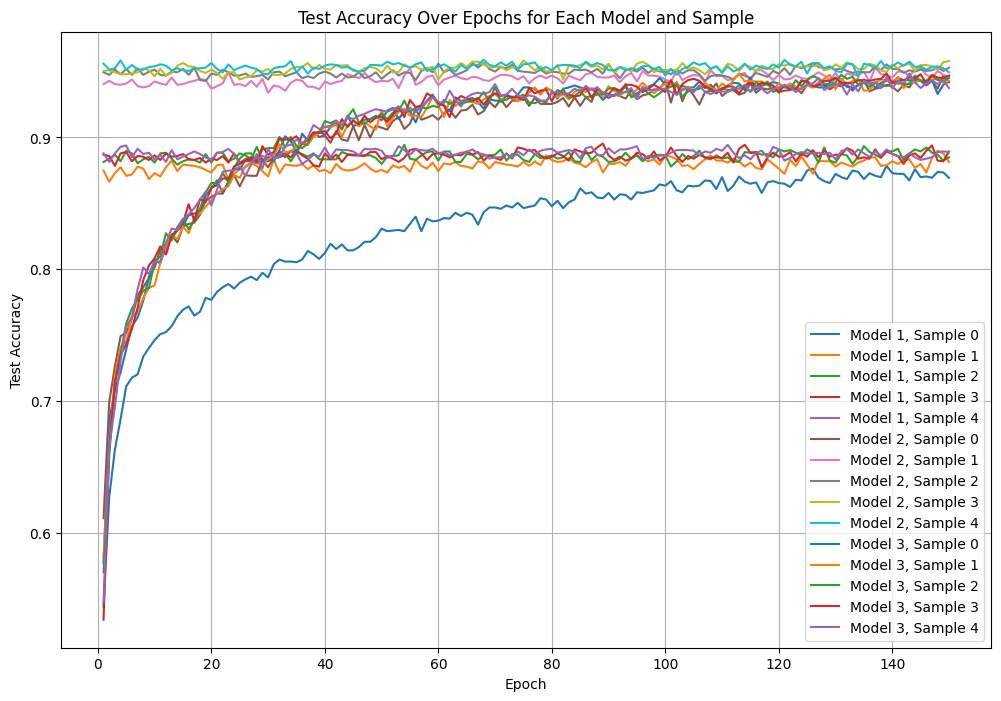

In [ ]:
import matplotlib.pyplot as plt

test_accuracy = pd.DataFrame(columns=['Model', 'Test Accuracy', 'Sample Number'])

model_names = all_iterations_df['Model'].unique()
sample_numbers = all_iterations_df['Sample Number'].unique()

# Plot test accuracy for each model and sample for 3 Models
plt.figure(figsize=(12, 8))
for model_name in model_names:
    for sample_number in sample_numbers:
        model_subset = all_iterations_df[(all_iterations_df['Model'] == model_name) & (all_iterations_df['Sample Number'] == sample_number)]
        plt.plot(range(1, num_epochs + 1), model_subset['Test Accuracy'], label=f'{model_name}, Sample {sample_number}')

plt.title('Test Accuracy Over Epochs for Each Model and Sample')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<Figure size 1200x800 with 0 Axes>

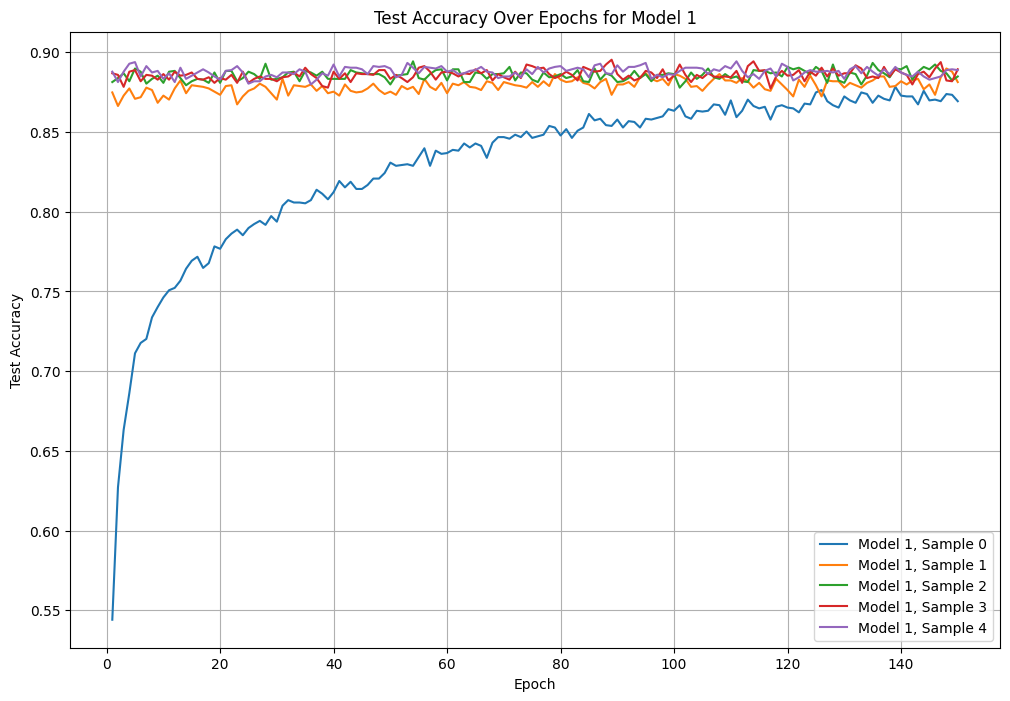

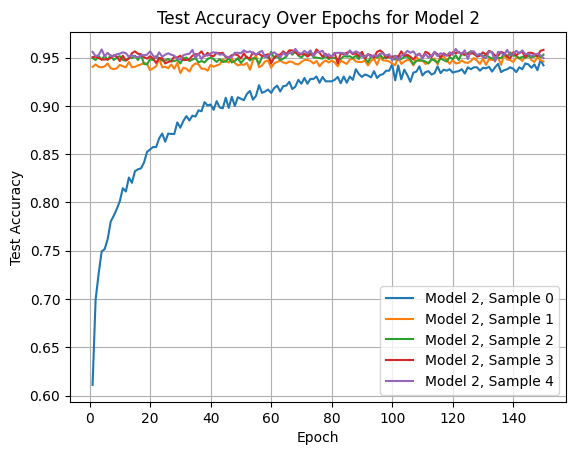

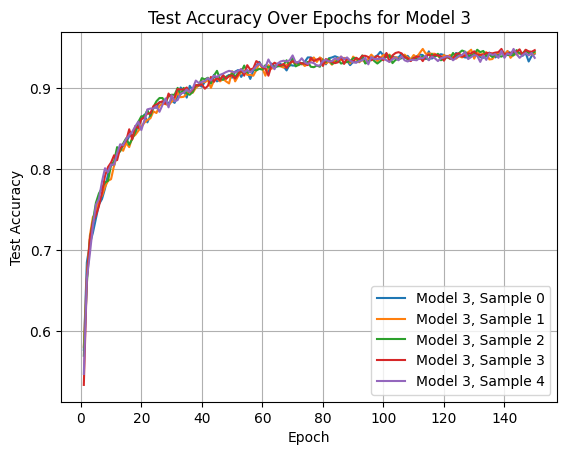

In [ ]:
plt.figure(figsize=(12, 8))

# Plot test accuracy for each model
plt.figure(figsize=(12, 8))
for model_name in model_names:
    for sample_number in sample_numbers:
        model_subset = all_iterations_df[(all_iterations_df['Model'] == model_name) & (all_iterations_df['Sample Number'] == sample_number)]
        plt.plot(range(1, num_epochs + 1), model_subset['Test Accuracy'], label=f'{model_name}, Sample {sample_number}')
    plt.title(f'Test Accuracy Over Epochs for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


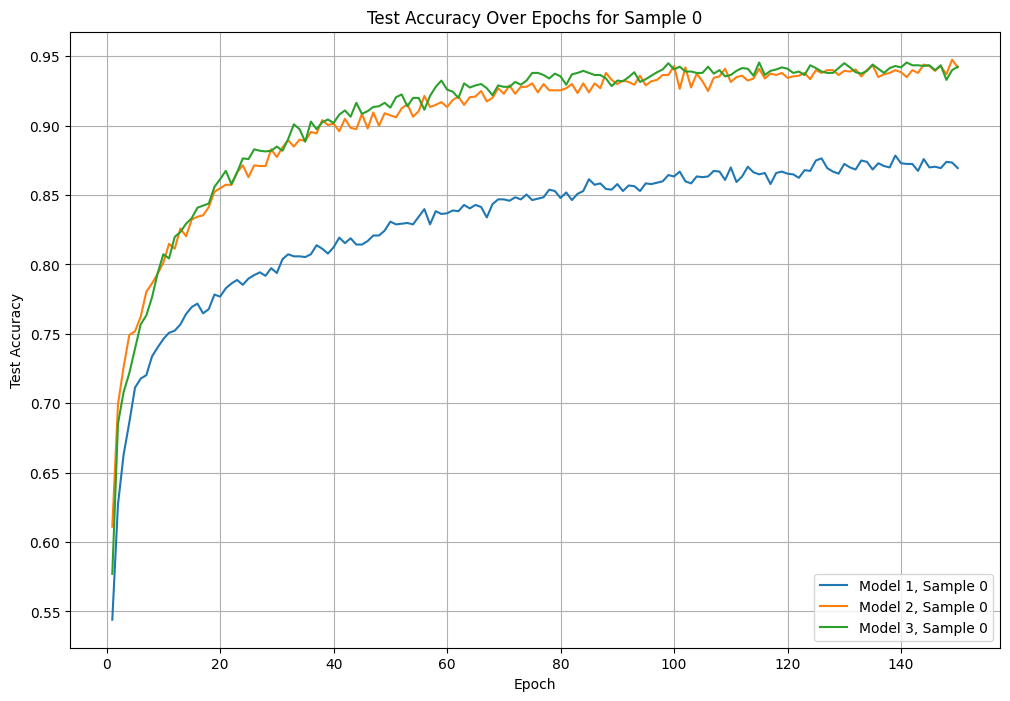

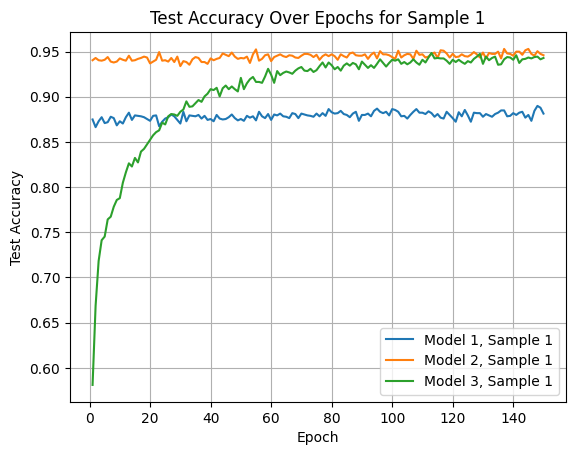

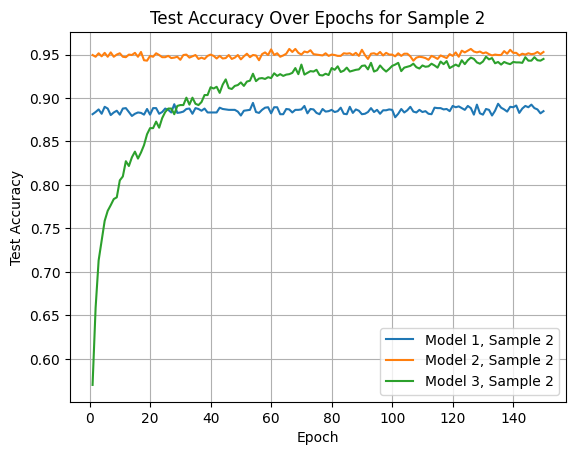

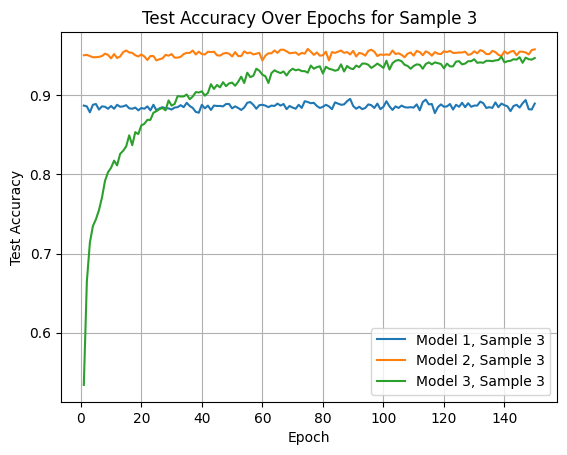

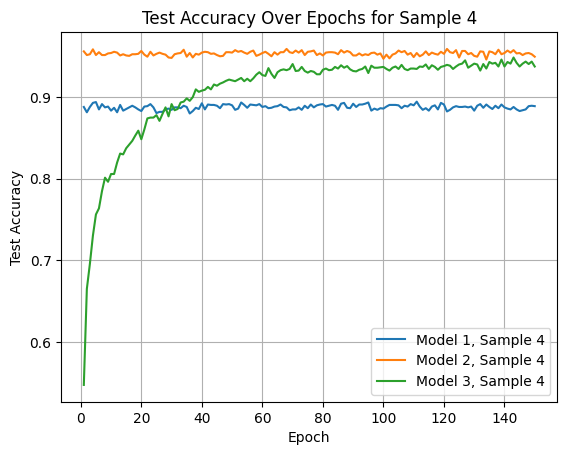

In [ ]:
# Plot test accuracy for each sample
plt.figure(figsize=(12, 8))
for sample_number in sample_numbers:
    for model_name in model_names:
        model_subset = all_iterations_df[(all_iterations_df['Model'] == model_name) & (all_iterations_df['Sample Number'] == sample_number)]
        plt.plot(range(1, num_epochs + 1), model_subset['Test Accuracy'], label=f'{model_name}, Sample {sample_number}')
    plt.title(f'Test Accuracy Over Epochs for Sample {sample_number}')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

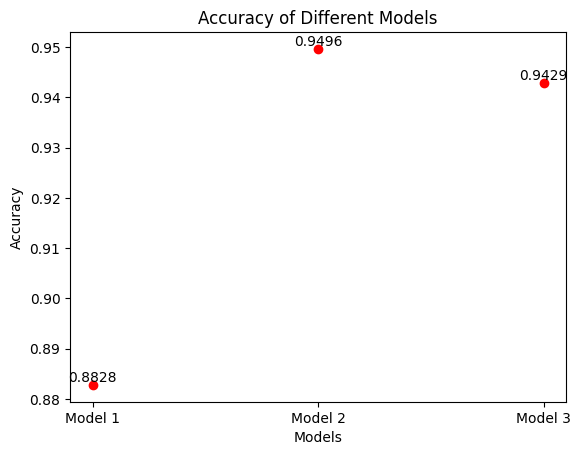

In [ ]:
#plot average test accuracy for 3 models
print(results_df)
average_df = results_df.groupby('Model')['Final Test Accuracy'].agg('mean').reset_index()
average_df = average_df.rename(columns={'Final Test Accuracy': 'Average Test Accuracy'})
print(average_df)

values = average_df['Average Test Accuracy']
labels = average_df['Model']
plt.scatter(labels, values, color='red')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
for label, value in zip(labels, values):
    plt.text(label, value, f'{value:.4f}', ha='center', va='bottom')
plt.show()
